# Lab-06: Time-Series Data Analysis

This lab covers the fundamental concepts of time-series data analysis using Google and Amazon stock prices over the last 5 years.

## Goals

This lab aims to answer the following questions:

- How can we select the appropriate time-scale for further analysis?
- How can we leverage data visualization to identify trends and/or data pre-processing steps?
- How can we use smoothing techniques to mitigate the impact of noise and why is this helpful?
- How can we leverage time-shifting to uncover useful correlations?

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import ccf
import seaborn as sns

## Stock Price Dataset

This dataset is composed of the following fields:
- **Date**: trading day
- **Open**: stock price at the beginning of the trading day
- **High**: highest stock price on that trading day
- **Low**: lowest stock price on that trading day
- **Close**: stock price at the end of trading day
- **Adj Close**: adjusts closing stock price to account for corporate actions (e.g. dividends)
- **Volume**: how many stocks were traded
- **company_name**: company stock belongs to (Google, Amazon, Apple, Microsoft)

Adjusted closing stock price is the standard benchmark for stock analysis. We will further investigate the adjusted closing stock price and sales volume of the four companies.

In [2]:
# Read the data from the CSV file
stocks_df = pd.read_csv('https://raw.githubusercontent.com/MIE223-2024/course-datasets/main/stock_data.csv', index_col='Date', parse_dates=True) # Significant to have index as date
stocks_df = stocks_df[(stocks_df['company_name'] == 'GOOGLE') | (stocks_df['company_name'] == 'AMAZON')] # Filter stocks for Google and Apple
stocks_df.head()

Open       High        Low      Close  Adj Close    Volume  \
Date                                                                          
2019-02-19  55.500000  56.094501  55.500000  55.928001  55.928001  20928000   
2019-02-20  55.999500  56.170502  55.264000  55.689999  55.689999  21756000   
2019-02-21  55.542000  55.597000  54.625999  54.848499  54.848499  28302000   
2019-02-22  55.044998  55.562000  54.779999  55.518501  55.518501  20990000   
2019-02-25  55.799999  55.926998  55.363499  55.470001  55.470001  28262000   

           company_name  
Date                     
2019-02-19       GOOGLE  
2019-02-20       GOOGLE  
2019-02-21       GOOGLE  
2019-02-22       GOOGLE  
2019-02-25       GOOGLE

In [3]:
# Keep only the columns we need
stocks_df = stocks_df[['Adj Close', 'Volume', 'company_name']]
stocks_df.head()

Adj Close    Volume company_name
Date                                        
2019-02-19  55.928001  20928000       GOOGLE
2019-02-20  55.689999  21756000       GOOGLE
2019-02-21  54.848499  28302000       GOOGLE
2019-02-22  55.518501  20990000       GOOGLE
2019-02-25  55.470001  28262000       GOOGLE

In [4]:
print(type(stocks_df.index))
print(type(stocks_df.index[0]))

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [5]:
# What if I didn't include parse_dates=True or index_col='Date'?
test_df = pd.read_csv('https://raw.githubusercontent.com/MIE223-2024/course-datasets/main/stock_data.csv')
test_df.head()

Date       Open       High        Low      Close  Adj Close  \
0  2019-02-19  42.427502  42.860001  42.372501  42.732498  41.138523   
1  2019-02-20  42.797501  43.330002  42.747501  43.007500  41.403271   
2  2019-02-21  42.950001  43.092499  42.575001  42.764999  41.169807   
3  2019-02-22  42.895000  43.250000  42.845001  43.242500  41.629509   
4  2019-02-25  43.540001  43.967499  43.487499  43.557499  41.932755   

      Volume company_name  
0   75891200        APPLE  
1  104457600        APPLE  
2   68998800        APPLE  
3   75652800        APPLE  
4   87493600        APPLE

In [6]:
print(type(test_df['Date']))
print(type(test_df['Date'][0]))

<class 'pandas.core.series.Series'>
<class 'str'>


In [7]:
# Convert the 'Date' column to DateTimeIndex
test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df = test_df.set_index('Date')
test_df.head()

Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2019-02-19  42.427502  42.860001  42.372501  42.732498  41.138523   75891200   
2019-02-20  42.797501  43.330002  42.747501  43.007500  41.403271  104457600   
2019-02-21  42.950001  43.092499  42.575001  42.764999  41.169807   68998800   
2019-02-22  42.895000  43.250000  42.845001  43.242500  41.629509   75652800   
2019-02-25  43.540001  43.967499  43.487499  43.557499  41.932755   87493600   

           company_name  
Date                     
2019-02-19        APPLE  
2019-02-20        APPLE  
2019-02-21        APPLE  
2019-02-22        APPLE  
2019-02-25        APPLE

In [8]:
print(type(test_df.index))
print(type(test_df.index[0]))

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


Notice the index of **stocks_df** is a **DateTimeIndex**, which will simplify many of the upcoming time-series data methods.

## Exploratory Data Analysis

In [9]:
# Verify there are no missing values
stocks_df.isnull().sum()

Adj Close       0
Volume          0
company_name    0
dtype: int64

In [10]:
# Check which dates are missing
date_range = pd.date_range(start=stocks_df.index.min(), end=stocks_df.index.max()) # Creates a date range (similar to Python range for numbers) from start date to end date
missing_dates = date_range.difference(stocks_df.index) # Returns the dates that are in date_range but not in stocks_df.index
missing_dates

DatetimeIndex(['2019-02-23', '2019-02-24', '2019-03-02', '2019-03-03',
               '2019-03-09', '2019-03-10', '2019-03-16', '2019-03-17',
               '2019-03-23', '2019-03-24',
               ...
               '2024-01-14', '2024-01-15', '2024-01-20', '2024-01-21',
               '2024-01-27', '2024-01-28', '2024-02-03', '2024-02-04',
               '2024-02-10', '2024-02-11'],
              dtype='datetime64[ns]', length=565, freq=None)

Note that most of these dates are weekends, as stocks are often not traded during weekends. Other possible dates could include common holidays such as Christmas.

In [11]:
# Percentage of missing dates that are weekends
weekends = missing_dates[missing_dates.weekday >= 5]
print("Percentage of missing dates that are weekends:", round(len(weekends)/len(missing_dates),2))

# Verify Christmas day is missing
christmas = pd.to_datetime('2019-12-25')
print("2019 Christmas is missing:", christmas in missing_dates)

Percentage of missing dates that are weekends: 0.92
2019 Christmas is missing: True


## Visualizing the Data

In [12]:
# Plot column value (e.g. Adj Close, Volume) by company on same plot
def plot_col_by_company_group(df, col_name):
    fig, ax = plt.subplots()
    for name, group in df.groupby('company_name'):
        group.plot(ax=ax, y=col_name, label=name, title=f"{col_name} by Company", xlabel="Date", ylabel=col_name, figsize=(15,7))

# Plot column value (e.g. Adj Close, Volume) by company on same subplot
def plot_col_by_company_separate(df, col_name):
    group_by_company = df.groupby('company_name')
    num_groups = len(group_by_company)
    fig, ax = plt.subplots(num_groups, 1, figsize=(15,15))
    for i, (name, group) in enumerate(group_by_company):
        group.plot(ax=ax[i], y=col_name, legend=False, title=f"{name} {col_name}", xlabel="Date", ylabel=col_name)

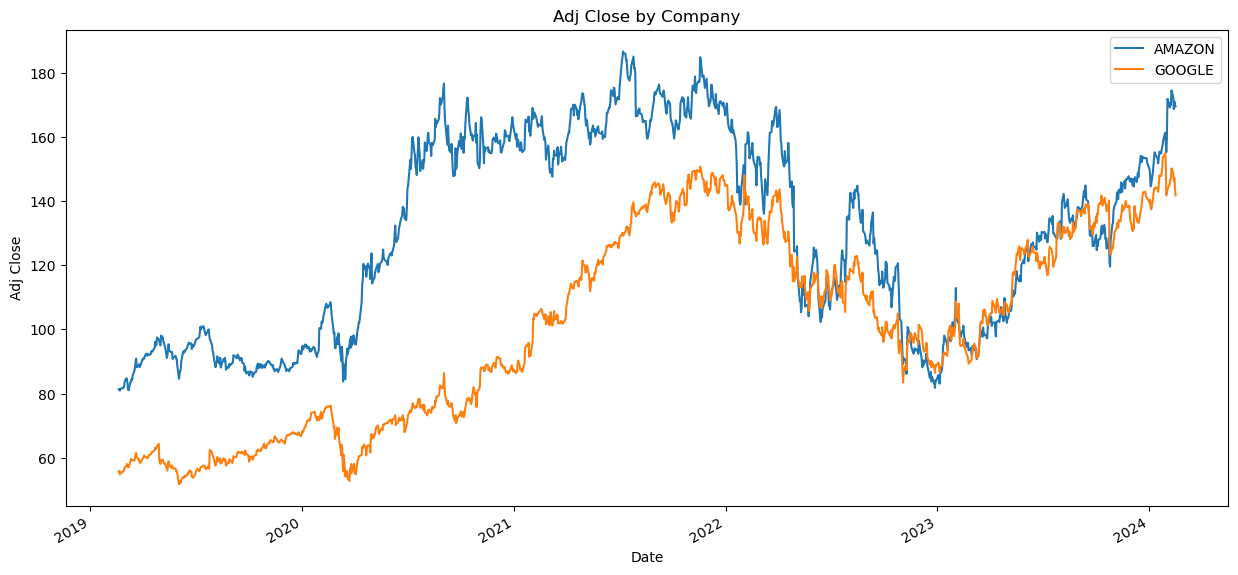

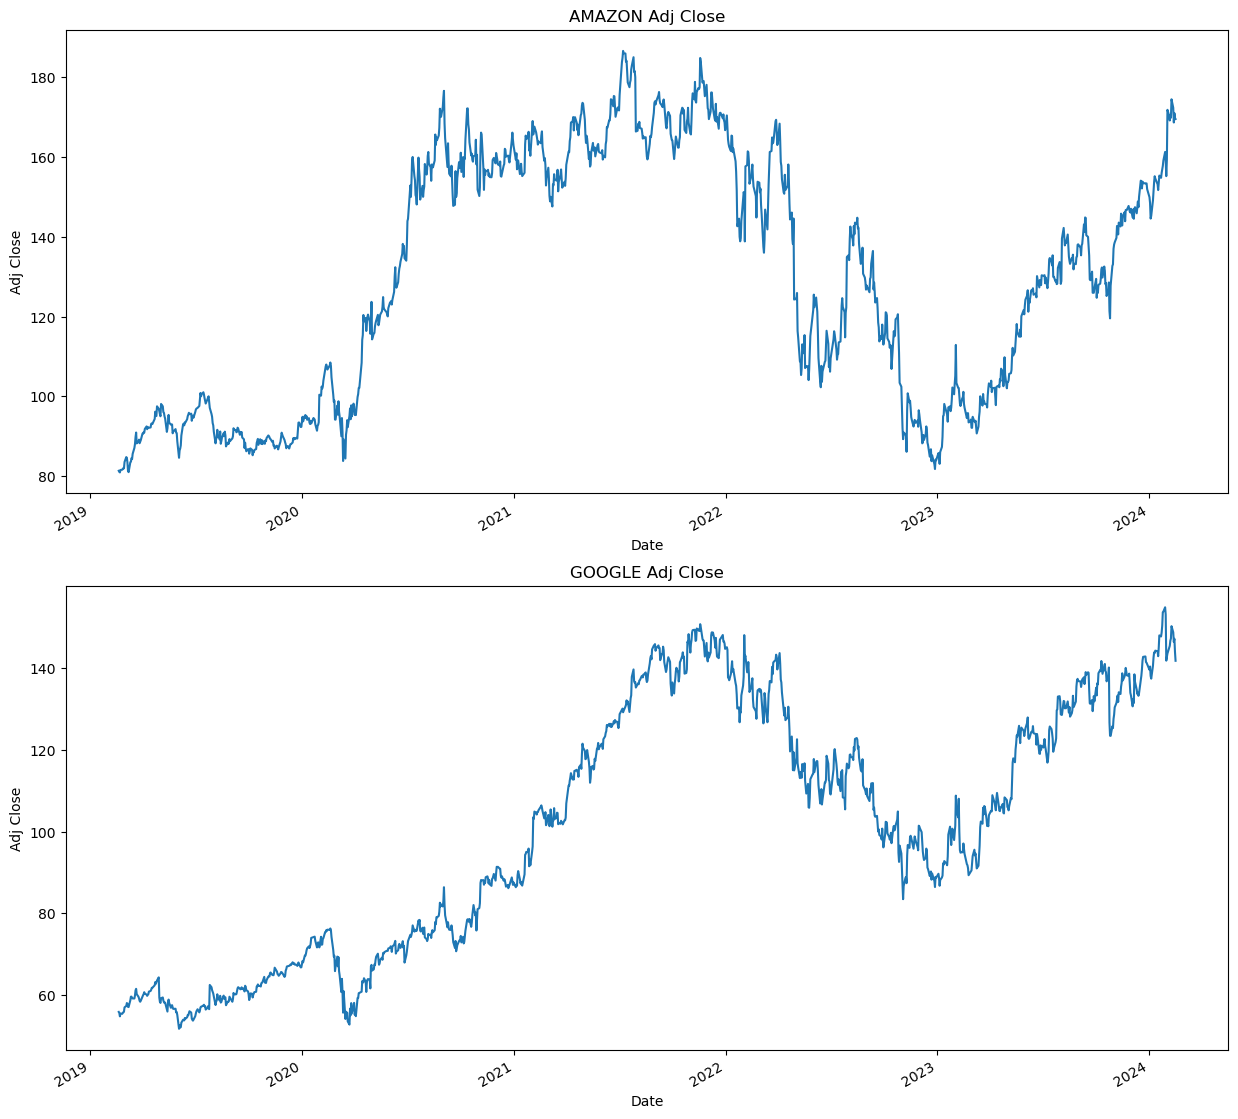

In [13]:
# Plot Adj Close by company on same plot
plot_col_by_company_group(stocks_df, 'Adj Close')

# Plot Adj Close by company on same plot
plot_col_by_company_separate(stocks_df, 'Adj Close')

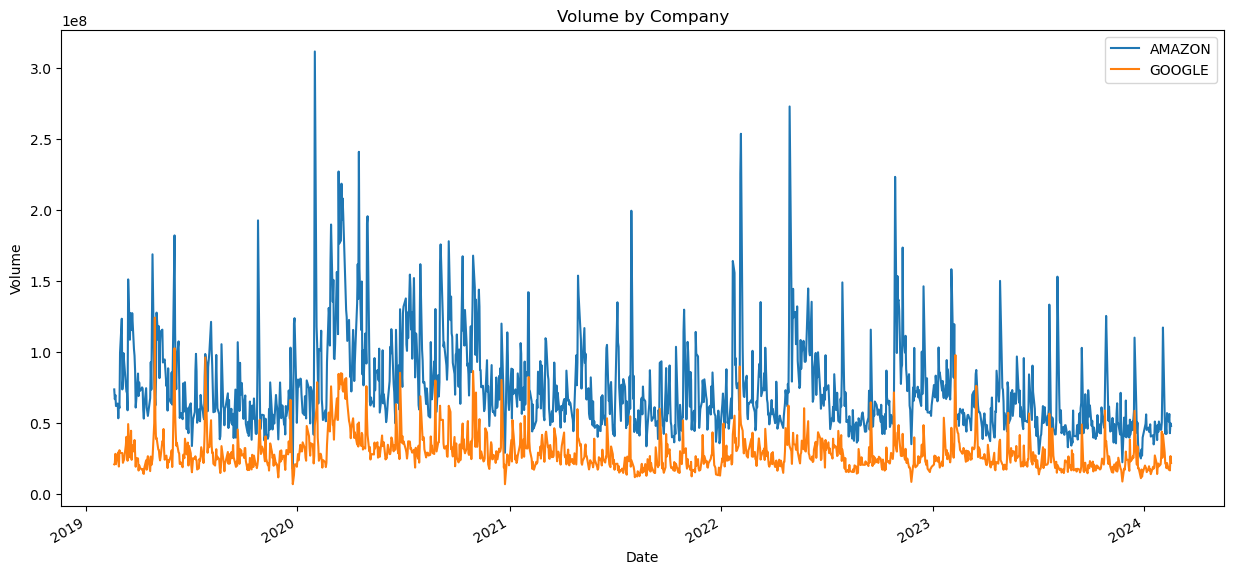

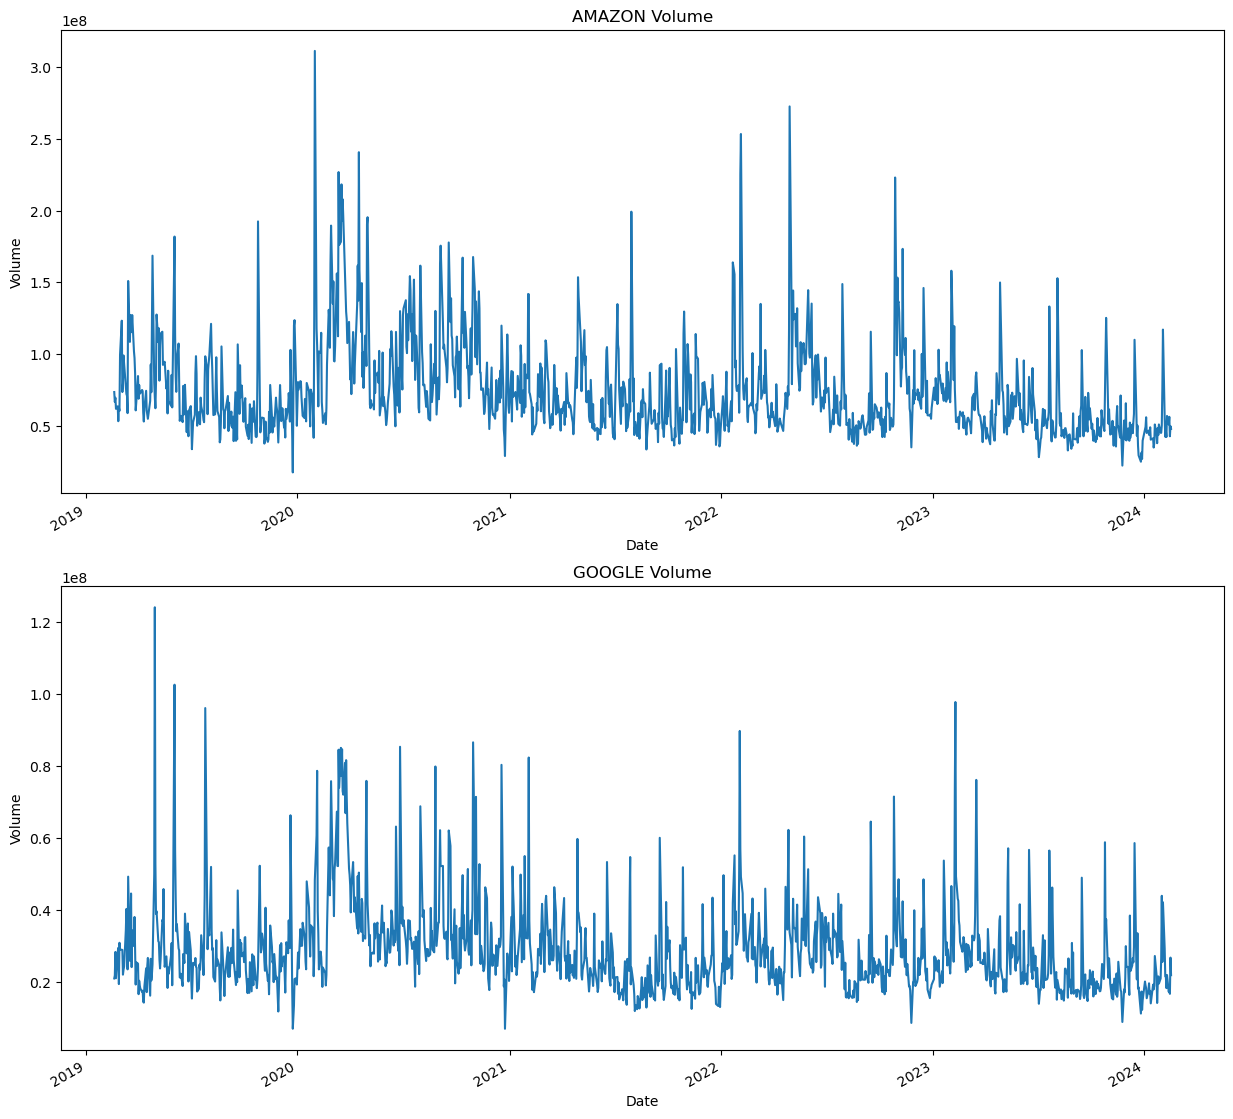

In [14]:
# Plot Volume by company on same plot
plot_col_by_company_group(stocks_df, 'Volume')

# Plot Volume by company on same plot
plot_col_by_company_separate(stocks_df, 'Volume')

## Resampling

Resampling refers to the adjusting the time scale of the time-series data. There are two general methods for this:

- **Upsampling**: adjusting the time-scale from a lower frequency to a higher frequency (e.g. months to weeks)
- **Downsampling**: adjusting the time-scale from a higher frequency to a lower frequency (e.g. weeks to months)

Upsampling is far less common in the context of time-series analysis, so we will focus on downsampling.

The table below denotes the Pandas shorthand for several time frequencies.

| Code  | Represents                                                          |
|-------|---------------------------------------------------------------------|
| D     | Calendar day                                                        |
| W     | Weekly                                                              |
| M     | Month end                                                           |
| Q     | Quarter end                                                         |
| A     | Year end                                                            |
| H     | Hours                                                               |
| T     | Minutes                                                             |
| S     | Seconds                                                             |
| B     | Business day                                                        |
| BM    | Business month end                                                  |
| BQ    | Business quarter end                                                |
| BA    | Business year end                                                   |
| BH    | Business hours                                                      |
| MS    | Month start                                                         |
| QS    | Quarter start                                                       |
| W-SUN | Weeks beginning with Sunday (similar for other days)                |
| 2M    | Every 2 months (works with other combinations of numbers and codes) |

### Downsampling

One of the most common downsampling method is computing an average over the specified time interval. Other methods such as taking a median over the interval can also be applied.

In [15]:
# Number of records in original dataframe
print("Original number of records:", len(stocks_df))

Original number of records: 2518


In [16]:
# Downsample the data to weekly
stocks_weekly = stocks_df.groupby('company_name').resample('W').mean()
stocks_weekly

Adj Close       Volume
company_name Date                               
AMAZON       2019-02-24   81.258501   67994500.0
             2019-03-03   82.220500   67999600.0
             2019-03-10   83.043001   93875600.0
             2019-03-17   84.331097   86161600.0
             2019-03-24   88.853000  120758800.0
...                             ...          ...
GOOGLE       2024-01-21  144.982502   20782775.0
             2024-01-28  150.834000   19235480.0
             2024-02-04  147.188000   31808120.0
             2024-02-11  146.891998   22465440.0
             2024-02-18  145.587997   20120080.0

[522 rows x 2 columns]

In [17]:
# Downsample the data to monthly
stocks_monthly = stocks_df.groupby('company_name').resample('M').mean()
stocks_monthly

Adj Close        Volume
company_name Date                                
AMAZON       2019-02-28   81.568750  6.405975e+07
             2019-03-31   86.124595  9.603067e+07
             2019-04-30   93.310119  7.737067e+07
             2019-05-31   93.469160  8.928582e+07
             2019-06-30   92.630875  7.474650e+07
...                             ...           ...
GOOGLE       2023-10-31  135.354091  2.340350e+07
             2023-11-30  134.868570  1.931600e+07
             2023-12-31  136.907500  2.410297e+07
             2024-01-31  145.425714  2.041768e+07
             2024-02-29  145.720832  2.338095e+07

[122 rows x 2 columns]

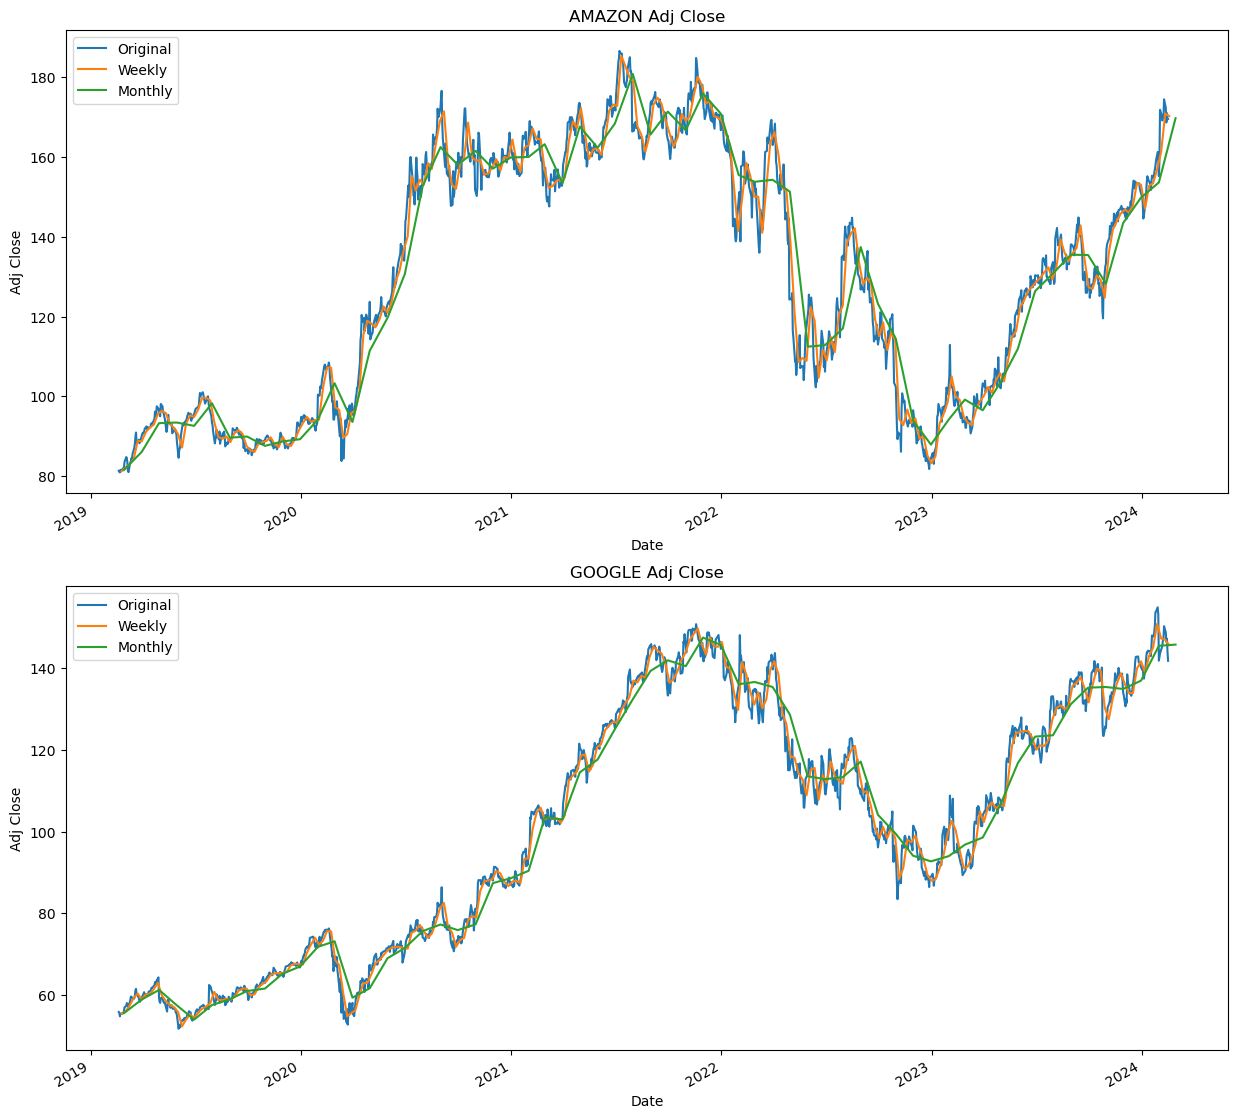

In [18]:
# Plot downsampled and original Adj Close by company on same subplot

stocks_df_grouped = stocks_df.groupby('company_name', group_keys=True)
num_groups = len(stocks_df_grouped)

fig, ax = plt.subplots(num_groups, 1, figsize=(15,15))
for i, (name, group) in enumerate(stocks_df_grouped):
    group.plot(ax=ax[i], y='Adj Close', label='Original', title=f"{name} Adj Close", xlabel="Date", ylabel="Adj Close")
    stocks_weekly.loc[name].plot(ax=ax[i], y='Adj Close', label='Weekly', xlabel="Date", ylabel="Adj Close")
    stocks_monthly.loc[name].plot(ax=ax[i], y='Adj Close', label='Monthly', xlabel="Date", ylabel="Adj Close")

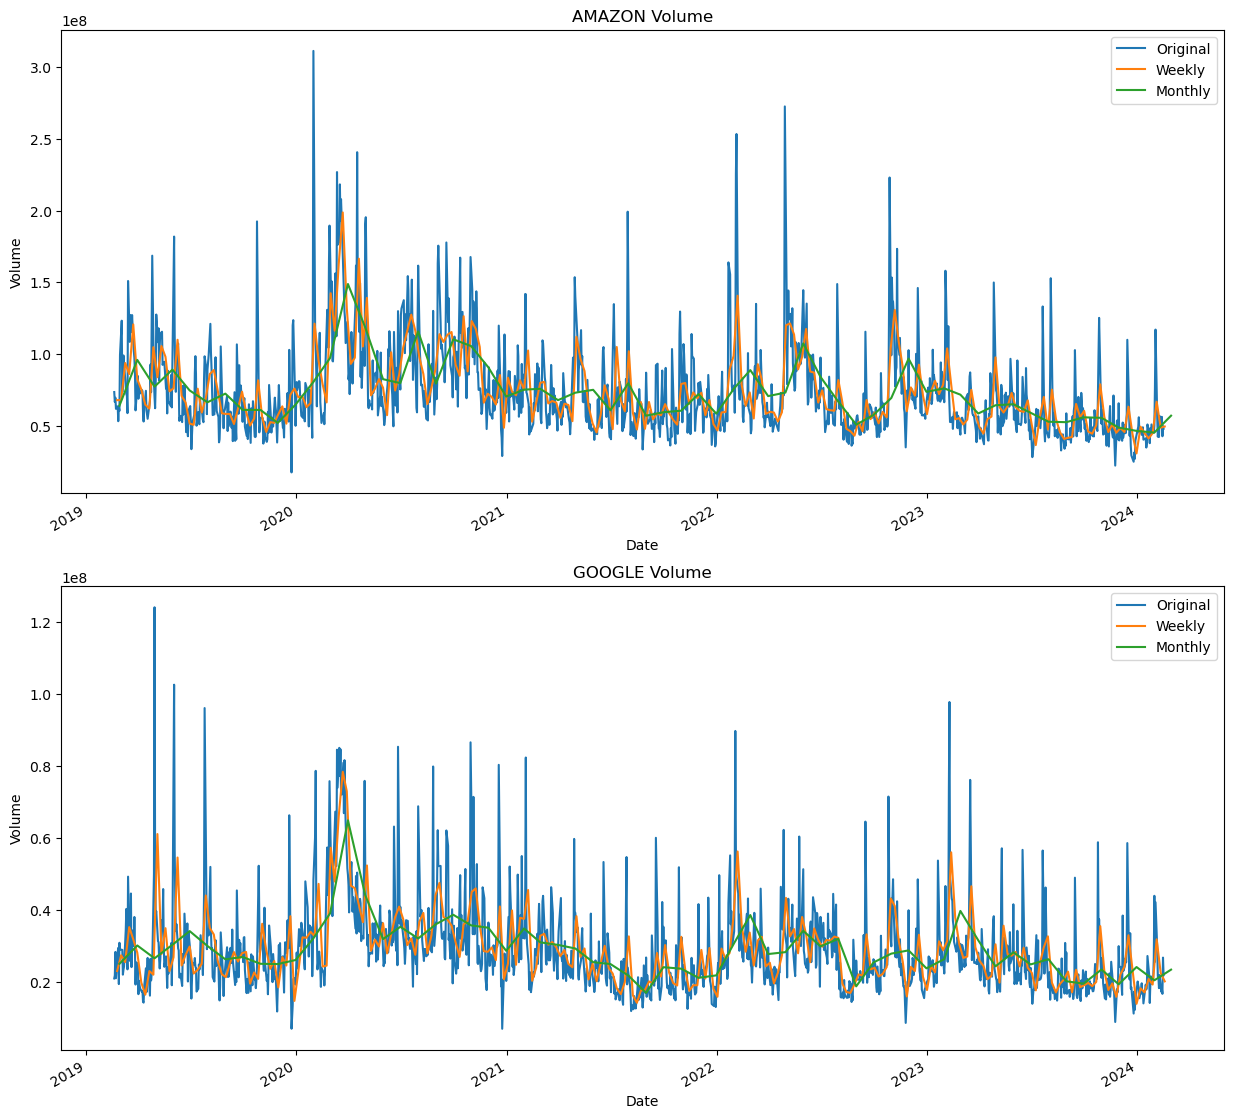

In [19]:
# Do the same for Volume

fig, ax = plt.subplots(num_groups, 1, figsize=(15,15))
for i, (name, group) in enumerate(stocks_df_grouped):
    group.plot(ax=ax[i], y='Volume', label='Original', title=f"{name} Volume", xlabel="Date", ylabel="Volume")
    stocks_weekly.loc[name].plot(ax=ax[i], y='Volume', label='Weekly', xlabel="Date", ylabel="Volume")
    stocks_monthly.loc[name].plot(ax=ax[i], y='Volume', label='Monthly', xlabel="Date", ylabel="Volume")

In [20]:
# Get variance of each setting for Adj Close and Volume
print('Original Dataset Variance:\n', stocks_df_grouped[['Adj Close', 'Volume']].var())
print('\nDownsampled Weekly Variance:\n', stocks_weekly.groupby(level=0)[['Adj Close', 'Volume']].var()) # Level = 0 is the company_name in the multilevel index
print('\nDownsampled Monthly Variance:\n', stocks_monthly.groupby(level=0)[['Adj Close', 'Volume']].var())

Original Dataset Variance:
                Adj Close        Volume
company_name                          
AMAZON        944.026018  1.056418e+15
GOOGLE        909.083620  1.638065e+14

Downsampled Weekly Variance:
                Adj Close        Volume
company_name                          
AMAZON        941.555762  6.262400e+14
GOOGLE        906.520958  9.627504e+13

Downsampled Monthly Variance:
                Adj Close        Volume
company_name                          
AMAZON        953.984335  3.867183e+14
GOOGLE        925.190250  5.544323e+13


Downsampling using average seems to have an indirect smoothing effect on the data.

### Upsampling

Although upsampling will not be explicitly covered in this lab, one of the most common methods is linear interpolation. An example of this procedure is provided below.

**Example:** Given the stock price at the beginning of month A is \$10 and the stock price at the end of month A is \$18, then the stock price at the end of each of the 4 weeks of month A can be linearly interpolated to be \$12, \$14, \$16, and \$18 (in that order).

## Smoothing

Smoothing methods reduce the effects of noise in the data to help uncover trends. The two most common smoothing methods are **moving averages** and **exponential smoothing**.

### Moving Average

A moving average is similar to the concept of a rolling window function from the previous lab.

**Simple Moving Average:**

The simplest definition of a moving average over a time window $k$ (e.g. k = 3 days, k = 5 months) is as follows: <br></br>
$$S_t = \frac{\sum_{i=1}^{k} X_{t-k+i}}{k}$$
where $X_{t-k+i}$ corresponds to values (or observations) within that rolling window.

**Weighted Moving Average:**

A weighted moving average assigns a weight to each value in the time window. <br></br>
$$S_t = \sum_{i=1}^{k} w_{t-k+i} \cdot X_{t-k+i}$$

Note that $\sum_{i=1}^{k} w_{t-k+i} = 1$. Often, higher weights are assigned to values at times closer to $t$.

**Causal vs. Non-Causal Moving Average:**

Causal moving averages can include values from the **future** within its rolling window. Non-causal moving averages are strictly limited to values from the **past**. For our purposes, we will stick to non-causal moving averages.

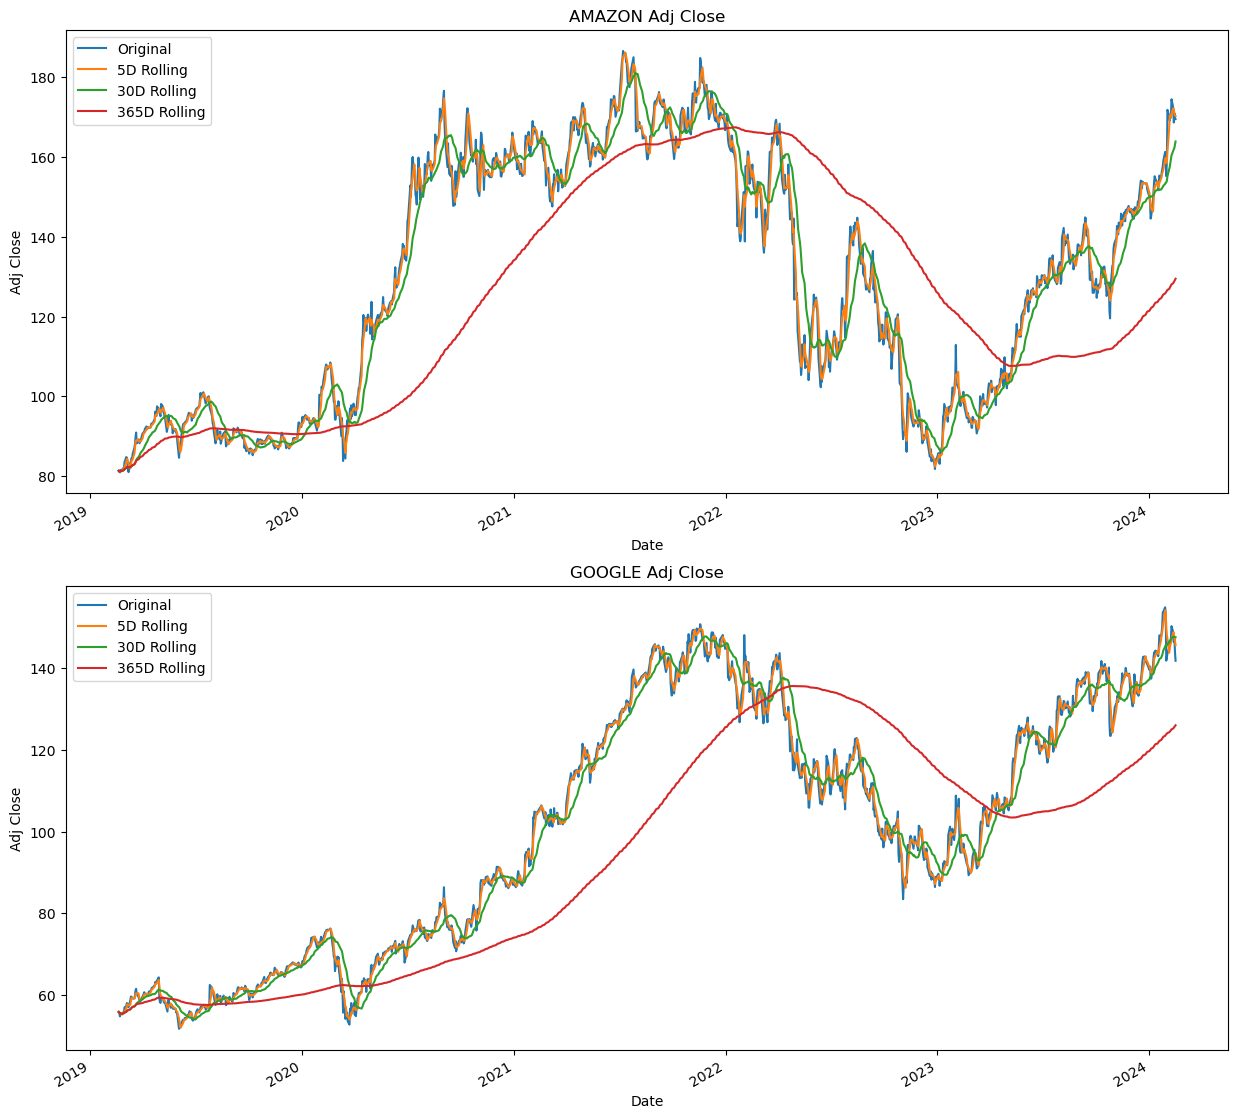

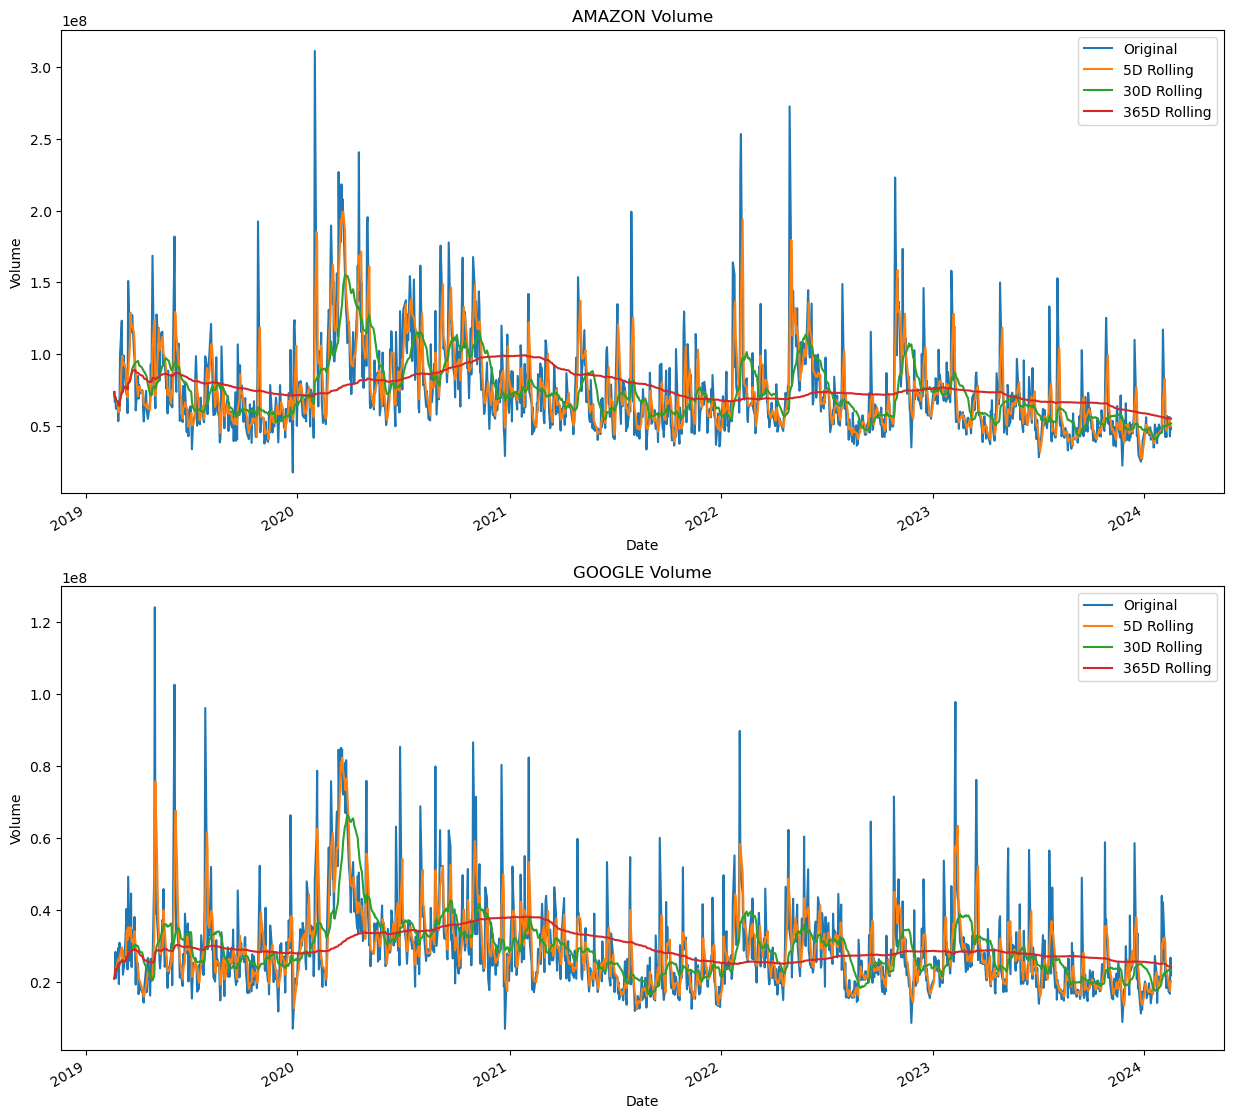

In [21]:
# Apply rolling window of 5, 30, and 365 days to the data
stocks_rolling_week = stocks_df_grouped.rolling(window='5D', min_periods=1).mean() # min_periods=1 means that if there are less than 5 days, it will still calculate the mean
stocks_rolling_month = stocks_df_grouped.rolling(window='30D', min_periods=1).mean()
stocks_rolling_year = stocks_df_grouped.rolling(window='365D', min_periods=1).mean()

# Plot original and rolling Adj Close by company on same subplot
fig, ax = plt.subplots(num_groups, 1, figsize=(15,15))
for i, (name, group) in enumerate(stocks_df_grouped):
    group.plot(ax=ax[i], y='Adj Close', label='Original', title=f"{name} Adj Close", xlabel="Date", ylabel="Adj Close")
    stocks_rolling_week.loc[name].plot(ax=ax[i], y='Adj Close', label='5D Rolling', xlabel="Date", ylabel="Adj Close")
    stocks_rolling_month.loc[name].plot(ax=ax[i], y='Adj Close', label='30D Rolling', xlabel="Date", ylabel="Adj Close")
    stocks_rolling_year.loc[name].plot(ax=ax[i], y='Adj Close', label='365D Rolling', xlabel="Date", ylabel="Adj Close")

# Do the same for Volume
fig, ax = plt.subplots(num_groups, 1, figsize=(15,15))
for i, (name, group) in enumerate(stocks_df_grouped):
    group.plot(ax=ax[i], y='Volume', label='Original', title=f"{name} Volume", xlabel="Date", ylabel="Volume")
    stocks_rolling_week.loc[name].plot(ax=ax[i], y='Volume', label='5D Rolling', xlabel="Date", ylabel="Volume")
    stocks_rolling_month.loc[name].plot(ax=ax[i], y='Volume', label='30D Rolling', xlabel="Date", ylabel="Volume")
    stocks_rolling_year.loc[name].plot(ax=ax[i], y='Volume', label='365D Rolling', xlabel="Date", ylabel="Volume")

In [22]:
# Get variance of each setting for Adj Close and Volume
print('Original Dataset Variance:\n', stocks_df_grouped[['Adj Close', 'Volume']].var())
print('\nRolling 5D Variance:\n', stocks_rolling_week.groupby(level=0)[['Adj Close', 'Volume']].var())
print('\nRolling 30D Variance:\n', stocks_rolling_month.groupby(level=0)[['Adj Close', 'Volume']].var())
print('\nRolling 365D Variance:\n', stocks_rolling_year.groupby(level=0)[['Adj Close', 'Volume']].var())

Original Dataset Variance:
                Adj Close        Volume
company_name                          
AMAZON        944.026018  1.056418e+15
GOOGLE        909.083620  1.638065e+14

Rolling 5D Variance:
                Adj Close        Volume
company_name                          
AMAZON        941.013371  7.286413e+14
GOOGLE        907.051876  1.061497e+14

Rolling 30D Variance:
                Adj Close        Volume
company_name                          
AMAZON        922.518049  3.990262e+14
GOOGLE        896.309791  5.473599e+13

Rolling 365D Variance:
                Adj Close        Volume
company_name                          
AMAZON        784.130934  9.478314e+13
GOOGLE        765.420322  1.368677e+13


Question to ask yourself - what is the effect of size of the rolling window on smoothing?

### Exponential Smoothing

Smoothing method which can be summarized using the following rules:<br></br>
$$s_0 = x_0$$
$$s_t = \alpha x_t + (1-\alpha) s_{t-1}$$

where $s_t$ represents the smoothed value at time $t$, $x_t$ represents the observation at time $t$, and $\alpha$ is the smoothing factor between 0 to 1.

**Example:** Apply exponential smoothing with a factor of $\alpha=0.5$ to the following observation set - [2, 4, 6, 8, 2]

**Solution:** <br></br>
$s_0 = 2$ <br></br>
$s_1 = 0.5(4) + 0.5(2) = 3$ <br></br>
$s_2 = 0.5(6) + 0.5(3) = 4.5$ <br></br>
$s_3 = 0.5(8) + 0.5(4.5) = 6.25$ <br></br>
$s_4 = 0.5(2) + 0.5(6.25) = 4.125$ <br></br>

**Exponential Smoothing vs. Moving Average:**

- Exponential smoothing is more computationally efficient (i.e. needs less memory) because it only stores 2 values (current value $x_t$ and previous smoothed value $s_{t-1}$) instead of $w$ values for moving average ($w$ is size of rolling window) .
- It is easier to fine-tune (i.e. find the best value suited for your data) a more constrained $\alpha \in [0,1]$, as opposed to finding the right size of the rolling window.
- Recursive formulation of exponential smoothing means estimate for $x_t$ is affected by all previous values before it ($\forall x_i, i \in [0, t-1]$) while the moving average estimate of $x_t$ is only affected by the most recent $w$ values ($\forall x_i, i \in [t-w+1, t]$). This implies that exponential smoothing better preserves trends of the original data than a moving average.

In [23]:
pd.Series([2,4,6,8,2]).ewm(alpha=0.5, adjust=False).mean() # adjust = False MANDATORY for recursive calculation

0    2.000
1    3.000
2    4.500
3    6.250
4    4.125
dtype: float64

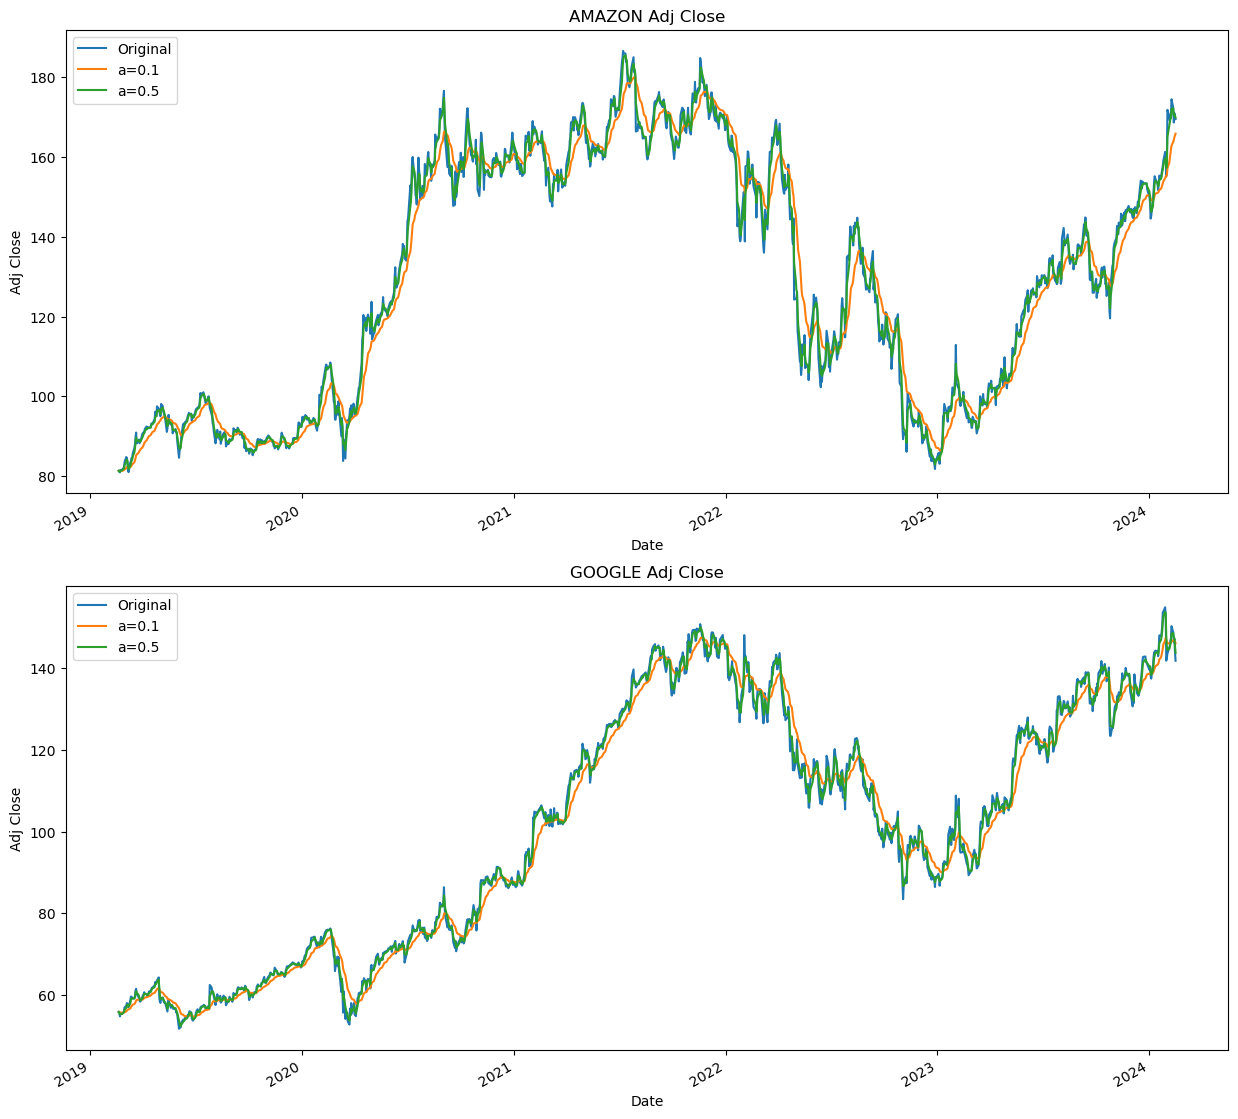

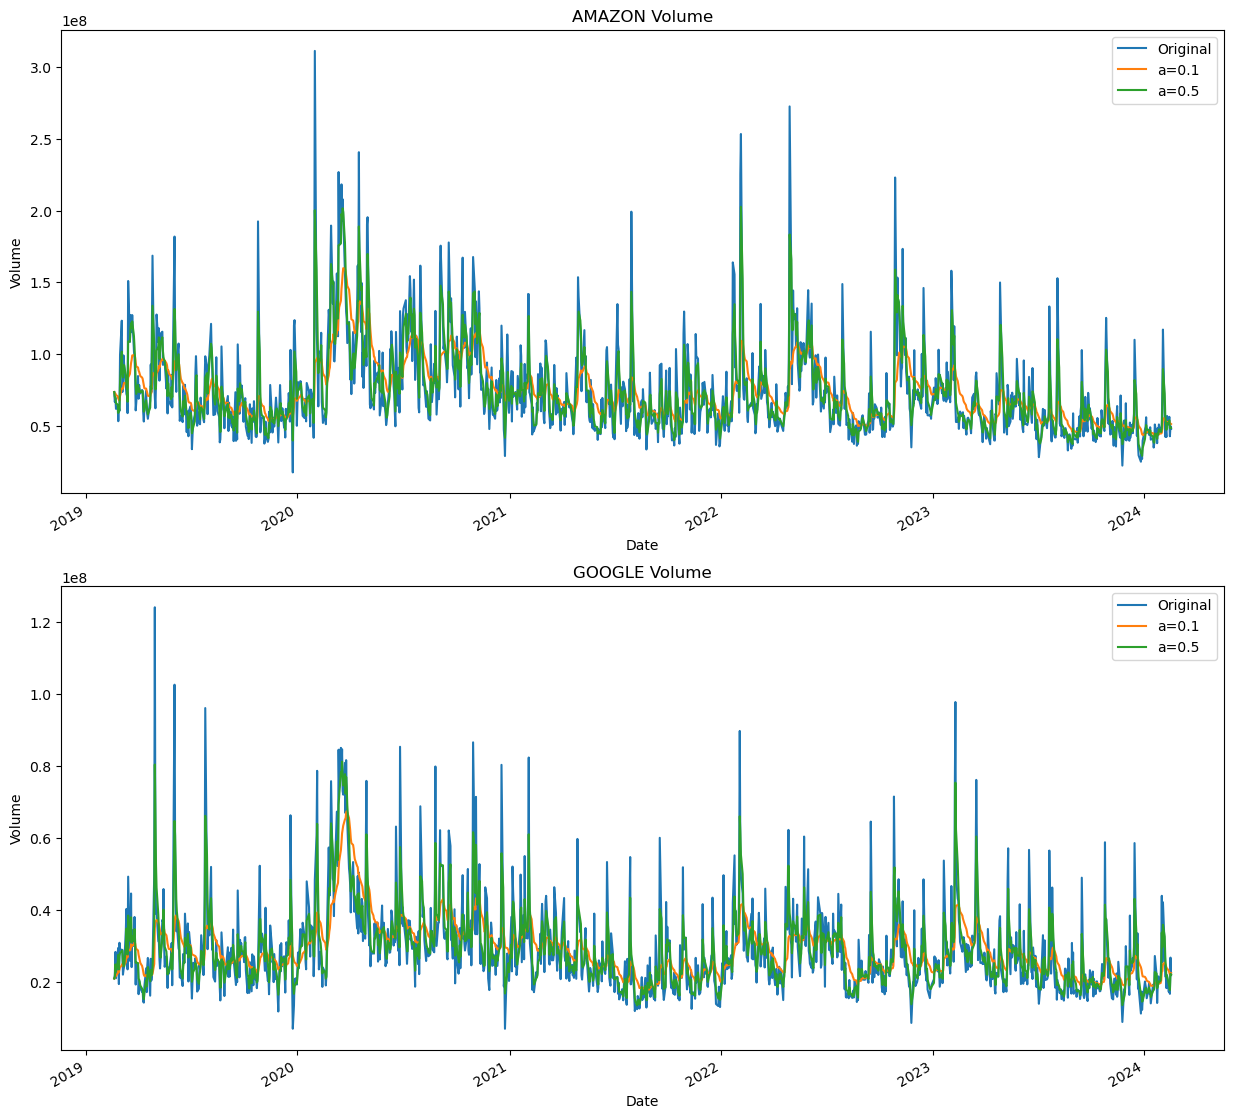

In [24]:
# Apply exponential smoothing to stock data with alpha = 0.1, 0.5, and 0.9
stocks_exp_01 = stocks_df_grouped.ewm(alpha=0.1, adjust=False).mean()
stocks_exp_05 = stocks_df_grouped.ewm(alpha=0.5, adjust=False).mean()
stocks_exp_09 = stocks_df_grouped.ewm(alpha=0.9, adjust=False).mean() # not included in the plot for visibility purposes

# Plot original and exponential smoothed Adj Close by company on same subplot
fig, ax = plt.subplots(num_groups, 1, figsize=(15,15))
for i, (name, group) in enumerate(stocks_df_grouped):
    group.plot(ax=ax[i], y='Adj Close', label='Original', title=f"{name} Adj Close", xlabel="Date", ylabel="Adj Close")
    stocks_exp_01.loc[name].plot(ax=ax[i], y='Adj Close', label='a=0.1', xlabel="Date", ylabel="Adj Close")
    stocks_exp_05.loc[name].plot(ax=ax[i], y='Adj Close', label='a=0.5', xlabel="Date", ylabel="Adj Close")

# Do the same for Volume
fig, ax = plt.subplots(num_groups, 1, figsize=(15,15))
for i, (name, group) in enumerate(stocks_df_grouped):
    group.plot(ax=ax[i], y='Volume', label='Original', title=f"{name} Volume", xlabel="Date", ylabel="Volume")
    stocks_exp_01.loc[name].plot(ax=ax[i], y='Volume', label='a=0.1', xlabel="Date", ylabel="Volume")
    stocks_exp_05.loc[name].plot(ax=ax[i], y='Volume', label='a=0.5', xlabel="Date", ylabel="Volume")

In [25]:
# Get variance of each setting for Adj Close and Volume
print('Original Dataset Variance:\n', stocks_df_grouped[['Adj Close', 'Volume']].var())
print('\nExponential 0.1 Variance:\n', stocks_exp_01.groupby(level=0)[['Adj Close', 'Volume']].var())
print('\nExponential 0.5 Variance:\n', stocks_exp_05.groupby(level=0)[['Adj Close', 'Volume']].var())

Original Dataset Variance:
                Adj Close        Volume
company_name                          
AMAZON        944.026018  1.056418e+15
GOOGLE        909.083620  1.638065e+14

Exponential 0.1 Variance:
                Adj Close        Volume
company_name                          
AMAZON        915.965805  3.916779e+14
GOOGLE        894.138357  5.444672e+13

Exponential 0.5 Variance:
                Adj Close        Volume
company_name                          
AMAZON        939.283744  7.267019e+14
GOOGLE        906.692135  1.073353e+14


Question to ask yourself - what is the effect of alpha on the smoothed results?

## Shifting

Time-series shifting refers to translating a time signal $n$ time steps forward or backward (also called lagging).

In [26]:
# Shift data 60 days forward
stocks_lag_60_forward = stocks_df_grouped.apply(lambda x: x.shift(periods=60))
stocks_lag_60_forward

Adj Close      Volume company_name
company_name Date                                           
AMAZON       2019-02-19         NaN         NaN         None
             2019-02-20         NaN         NaN         None
             2019-02-21         NaN         NaN         None
             2019-02-22         NaN         NaN         None
             2019-02-25         NaN         NaN         None
...                             ...         ...          ...
GOOGLE       2024-02-12  135.429993  22317300.0       GOOGLE
             2024-02-13  136.380005  15840900.0       GOOGLE
             2024-02-14  138.699997  17615100.0       GOOGLE
             2024-02-15  136.940002  25565300.0       GOOGLE
             2024-02-16  137.919998  19569400.0       GOOGLE

[2518 rows x 3 columns]

First 60 values are NaN there are no previous 60 values to shift forward.

In [27]:
stocks_lag_60_backward = stocks_df_grouped.apply(lambda x: x.shift(periods=-60))
stocks_lag_60_backward

Adj Close      Volume company_name
company_name Date                                          
AMAZON       2019-02-19  93.557503  93852000.0       AMAZON
             2019-02-20  95.378502  94156000.0       AMAZON
             2019-02-21  93.449997  94732000.0       AMAZON
             2019-02-22  92.948502  75964000.0       AMAZON
             2019-02-25  92.875999  80102000.0       AMAZON
...                            ...         ...          ...
GOOGLE       2024-02-12        NaN         NaN         None
             2024-02-13        NaN         NaN         None
             2024-02-14        NaN         NaN         None
             2024-02-15        NaN         NaN         None
             2024-02-16        NaN         NaN         None

[2518 rows x 3 columns]

Last 60 values are NaN there are no successive 60 values to shift backward.

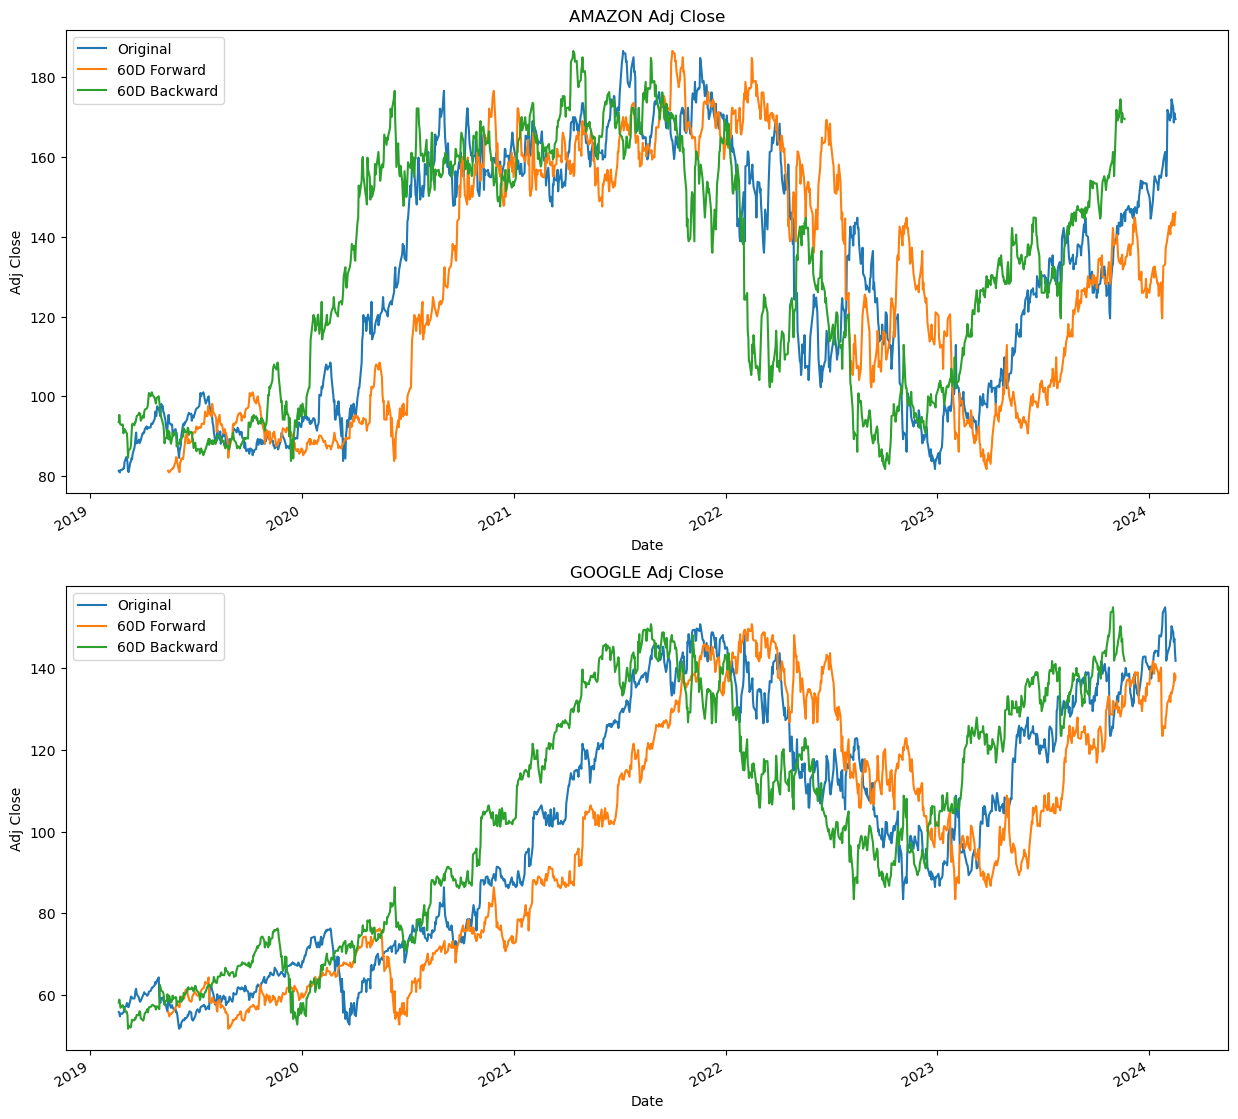

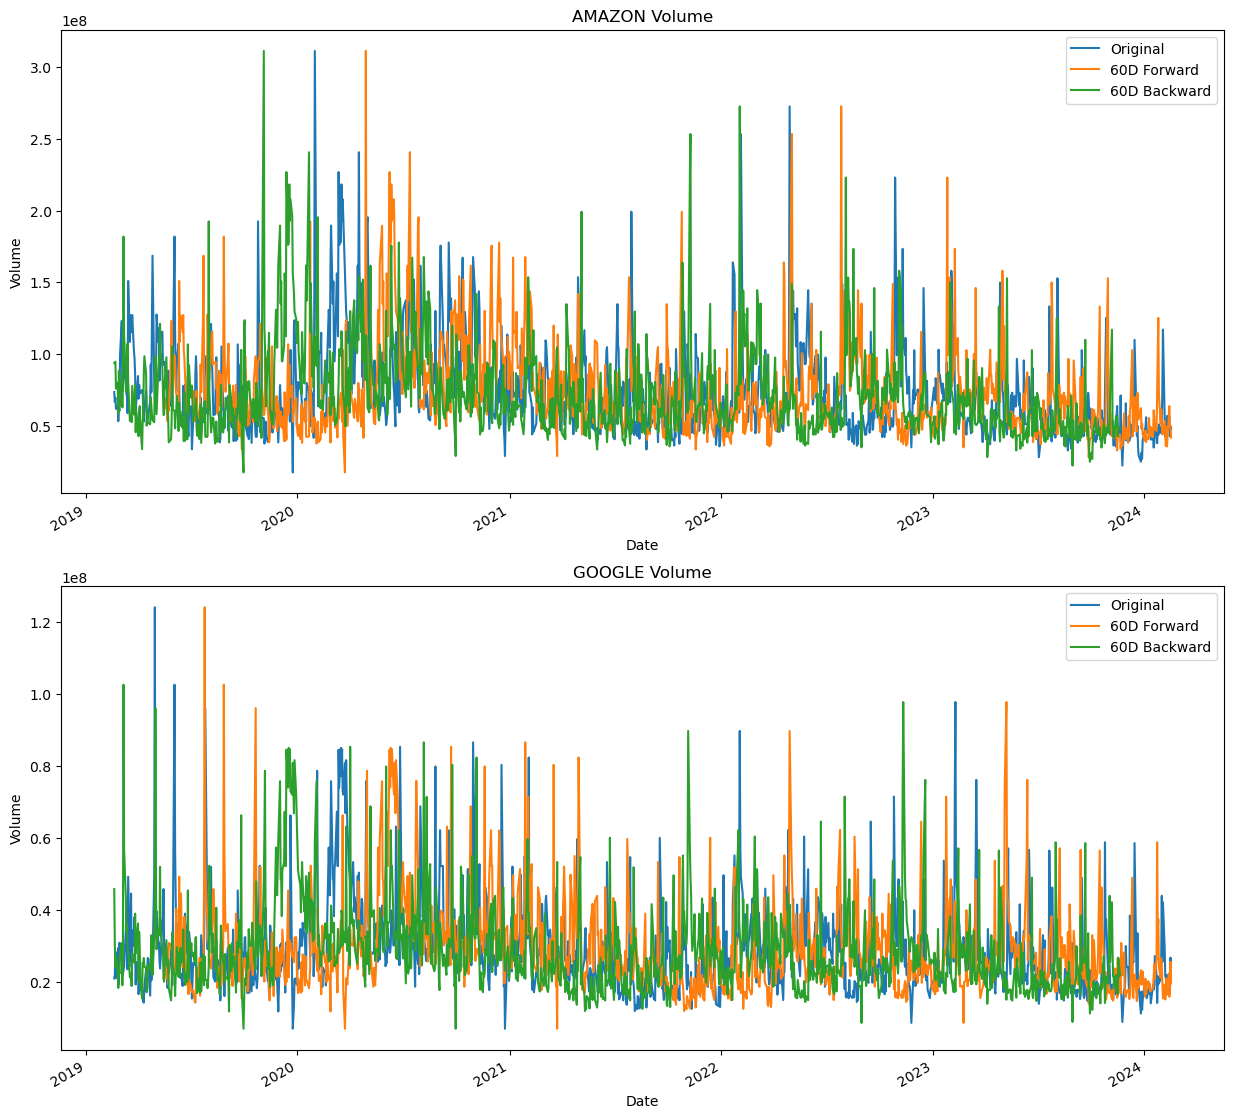

In [28]:
# Plot original and lagged Adj Close by company on same subplot
fig, ax = plt.subplots(num_groups, 1, figsize=(15,15))
for i, (name, group) in enumerate(stocks_df_grouped):
    group.plot(ax=ax[i], y='Adj Close', label='Original', title=f"{name} Adj Close", xlabel="Date", ylabel="Adj Close")
    stocks_lag_60_forward.loc[name].plot(ax=ax[i], y='Adj Close', label='60D Forward', xlabel="Date", ylabel="Adj Close")
    stocks_lag_60_backward.loc[name].plot(ax=ax[i], y='Adj Close', label='60D Backward', xlabel="Date", ylabel="Adj Close")

# Do the same for Volume
fig, ax = plt.subplots(num_groups, 1, figsize=(15,15))
for i, (name, group) in enumerate(stocks_df_grouped):
    group.plot(ax=ax[i], y='Volume', label='Original', title=f"{name} Volume", xlabel="Date", ylabel="Volume")
    stocks_lag_60_forward.loc[name].plot(ax=ax[i], y='Volume', label='60D Forward', xlabel="Date", ylabel="Volume")
    stocks_lag_60_backward.loc[name].plot(ax=ax[i], y='Volume', label='60D Backward', xlabel="Date", ylabel="Volume")

## Correlation

Correlation measures and plots can be used to uncover patterns or relationships between variables.

There are two common patterns that often appear in time-series data.
1. **Trends:** consistent growth or decline over time (often linear)
2. **Seasonality:** periodic pattern (like a sine wave)

### Autocorrelation

Autocorrelation plots can be used to detect possible trends and/or seasonality.

It involves computing the correlation between the original time-series data and a time-shifted version of it. This is done across multiple lag factors to see whether any pattern arises from correlations across different lags.  

#### Trends

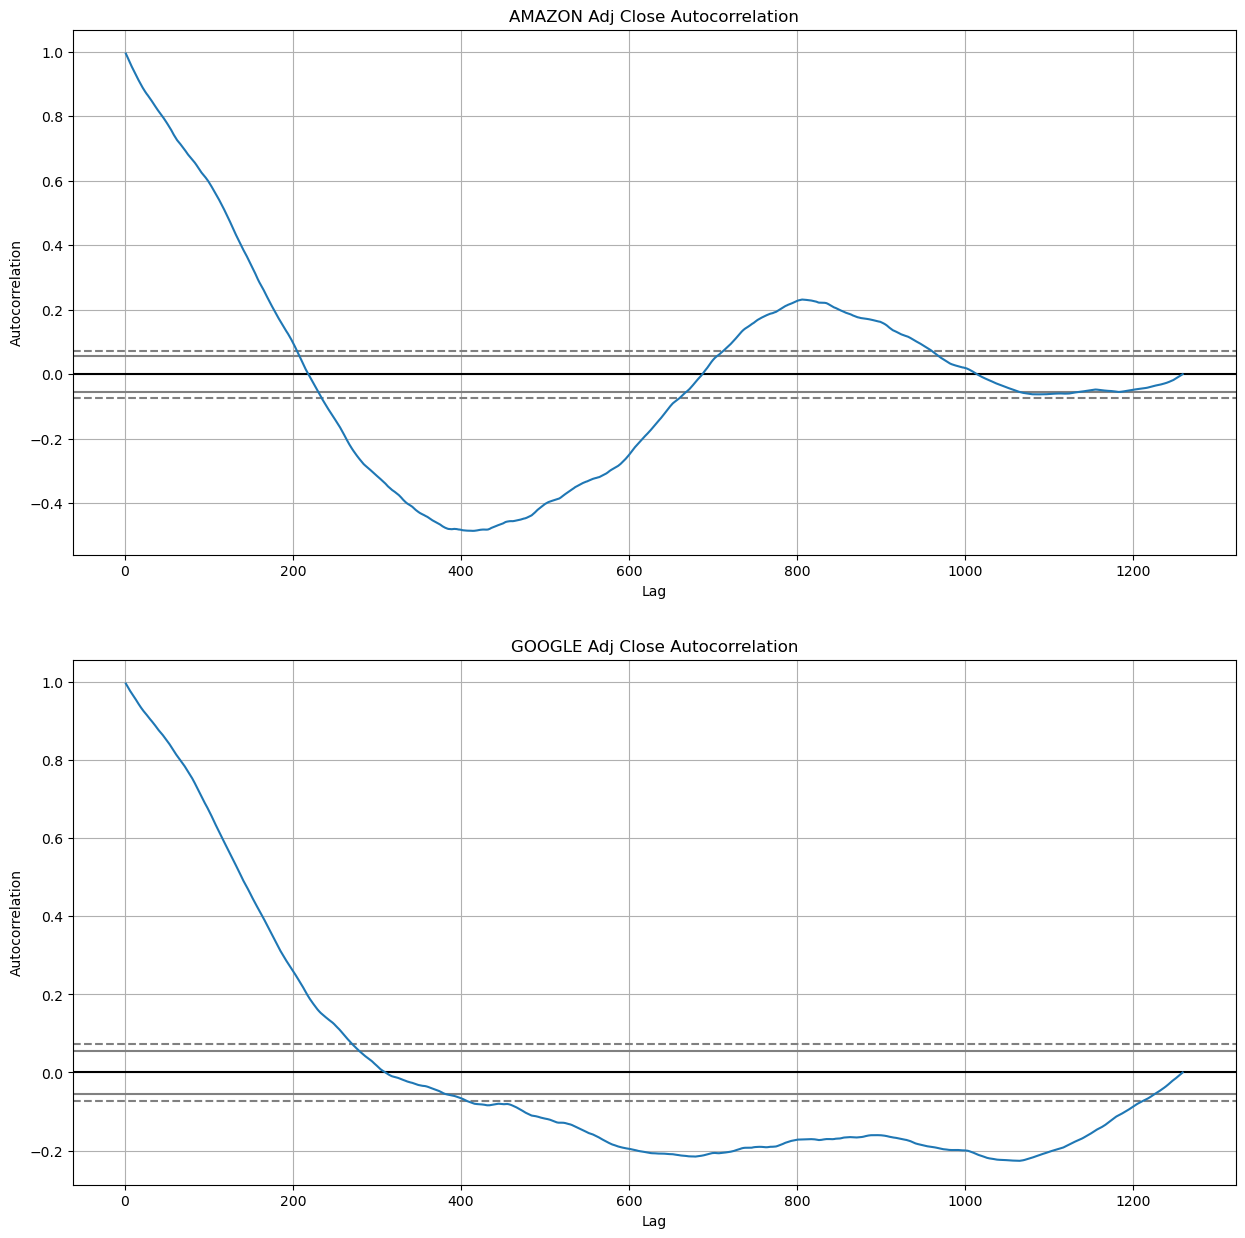

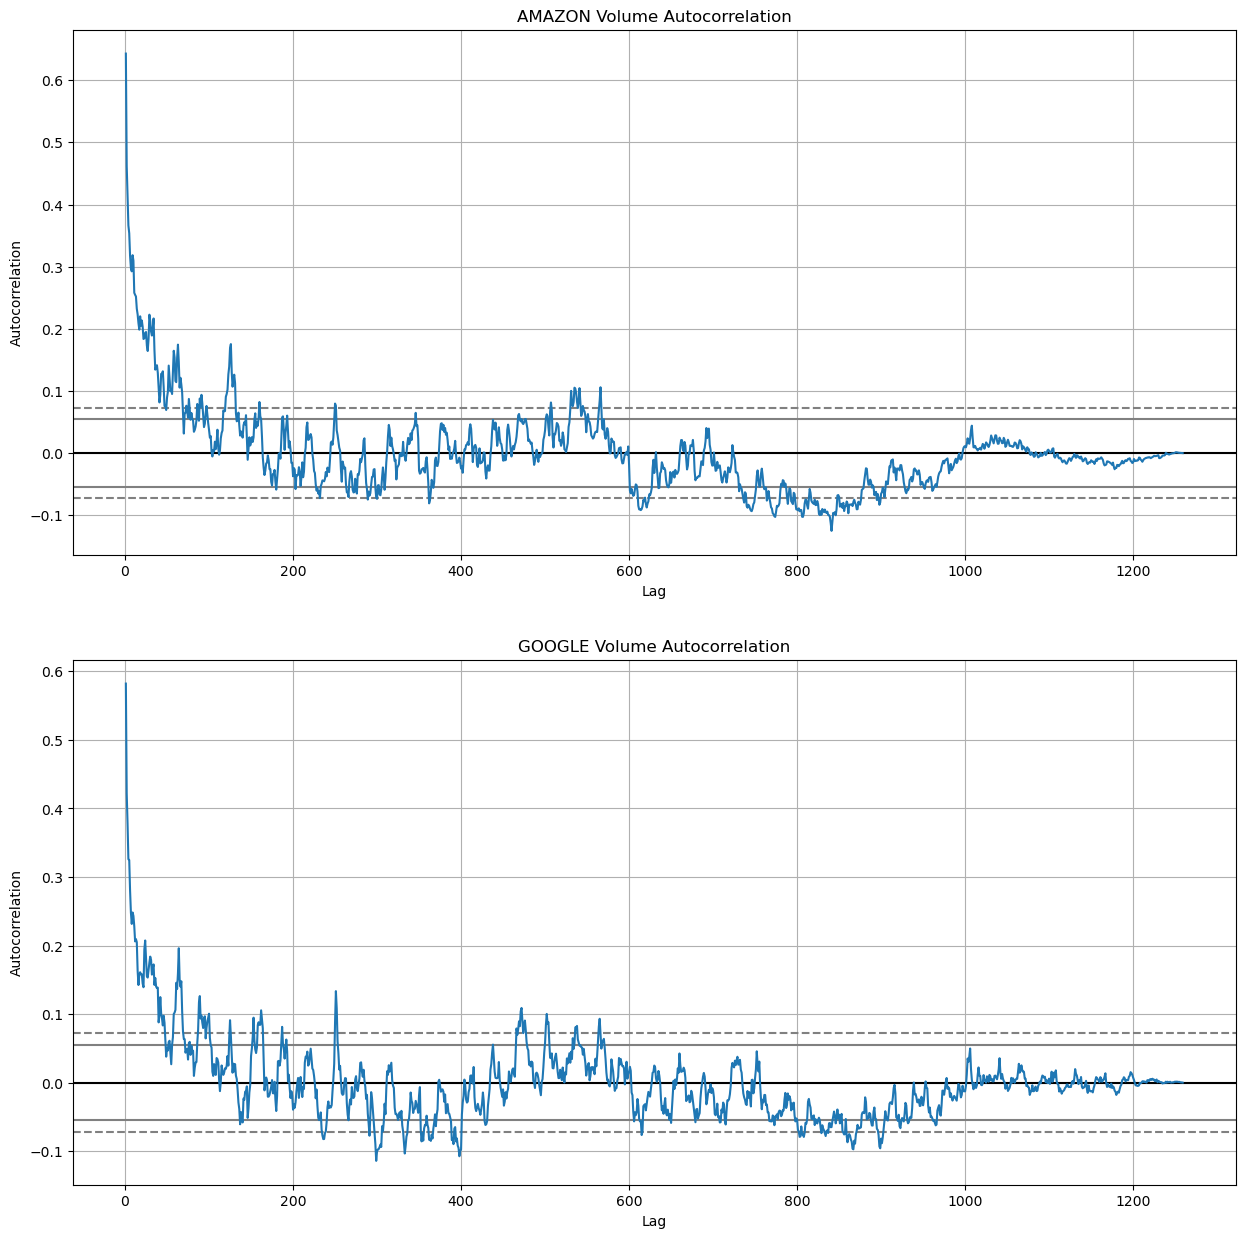

In [29]:
# Auto-correlation plot for Adj Close
fig, ax = plt.subplots(num_groups, 1, figsize=(15,15))
for i, (name, group) in enumerate(stocks_df_grouped):
    pd.plotting.autocorrelation_plot(group['Adj Close'], ax=ax[i])
    ax[i].set_title(f"{name} Adj Close Autocorrelation")

# Auto-correlation plot for Volume
fig, ax = plt.subplots(num_groups, 1, figsize=(15,15))
for i, (name, group) in enumerate(stocks_df_grouped):
    pd.plotting.autocorrelation_plot(group['Volume'], ax=ax[i])
    ax[i].set_title(f"{name} Volume Autocorrelation")

Decreasing autocorrelation plot with sharp decline after lower lag values is indicative of a trend (typically linear).

#### Seasonal

Here, we use a dataset of historical daily temperature in the following cities: Toronto, Ottawa, Calgary, Edmonton, Sydney, and Buenos Aires. 

In [30]:
# Load temperature data
temperature_df = pd.read_csv('https://raw.githubusercontent.com/MIE223-2024/course-datasets/main/cities_temperature.csv')
temperature_df.head()

Region    Country  State    City  Month  Day  Year  \
0  Australia/South Pacific  Australia    NaN  Sydney      1    1  1995   
1  Australia/South Pacific  Australia    NaN  Sydney      1    2  1995   
2  Australia/South Pacific  Australia    NaN  Sydney      1    3  1995   
3  Australia/South Pacific  Australia    NaN  Sydney      1    4  1995   
4  Australia/South Pacific  Australia    NaN  Sydney      1    5  1995   

   AvgTemperature  
0            59.1  
1            64.6  
2            79.1  
3            77.3  
4            70.2

In [31]:
# Cities of interest
city_1 = "Toronto"
city_2 = "Sydney"
city_3 = "Ottawa"

# Extract data for cities
city_1_df = temperature_df[temperature_df['City'] == city_1].copy() # Use copy to avoid SettingWithCopyWarning
city_2_df = temperature_df[temperature_df['City'] == city_2].copy()
city_3_df = temperature_df[temperature_df['City'] == city_3].copy()

city_1_df.head()

Region Country  State     City  Month  Day  Year  AvgTemperature
30863  North America  Canada    NaN  Toronto      1    1  1995            33.0
30864  North America  Canada    NaN  Toronto      1    2  1995            25.2
30865  North America  Canada    NaN  Toronto      1    3  1995            21.5
30866  North America  Canada    NaN  Toronto      1    4  1995            13.4
30867  North America  Canada    NaN  Toronto      1    5  1995            12.0

In [32]:
# Create new Date column by aggregating Month, Day, and Year columns to MM/DD/YYYY format, then convert to DateTimeIndex

city_1_df['Date'] = pd.to_datetime(city_1_df['Month'].astype(str) + '/' + city_1_df['Day'].astype(str) + '/' + city_1_df['Year'].astype(str))
city_1_df = city_1_df.set_index('Date')

city_2_df['Date'] = pd.to_datetime(city_2_df['Month'].astype(str) + '/' + city_2_df['Day'].astype(str) + '/' + city_2_df['Year'].astype(str))
city_2_df = city_2_df.set_index('Date')

city_3_df['Date'] = pd.to_datetime(city_3_df['Month'].astype(str) + '/' + city_3_df['Day'].astype(str) + '/' + city_3_df['Year'].astype(str))
city_3_df = city_3_df.set_index('Date')

city_1_df.head()

Region Country  State     City  Month  Day  Year  \
Date                                                                  
1995-01-01  North America  Canada    NaN  Toronto      1    1  1995   
1995-01-02  North America  Canada    NaN  Toronto      1    2  1995   
1995-01-03  North America  Canada    NaN  Toronto      1    3  1995   
1995-01-04  North America  Canada    NaN  Toronto      1    4  1995   
1995-01-05  North America  Canada    NaN  Toronto      1    5  1995   

            AvgTemperature  
Date                        
1995-01-01            33.0  
1995-01-02            25.2  
1995-01-03            21.5  
1995-01-04            13.4  
1995-01-05            12.0

In [33]:
# Keep only the columns we need
city_1_df = city_1_df[['AvgTemperature']]
city_2_df = city_2_df[['AvgTemperature']]
city_3_df = city_3_df[['AvgTemperature']]

city_1_df.head()

AvgTemperature
Date                      
1995-01-01            33.0
1995-01-02            25.2
1995-01-03            21.5
1995-01-04            13.4
1995-01-05            12.0

<Axes: title={'center': 'Ottawa Temperature'}, xlabel='Date', ylabel='Temperature'>

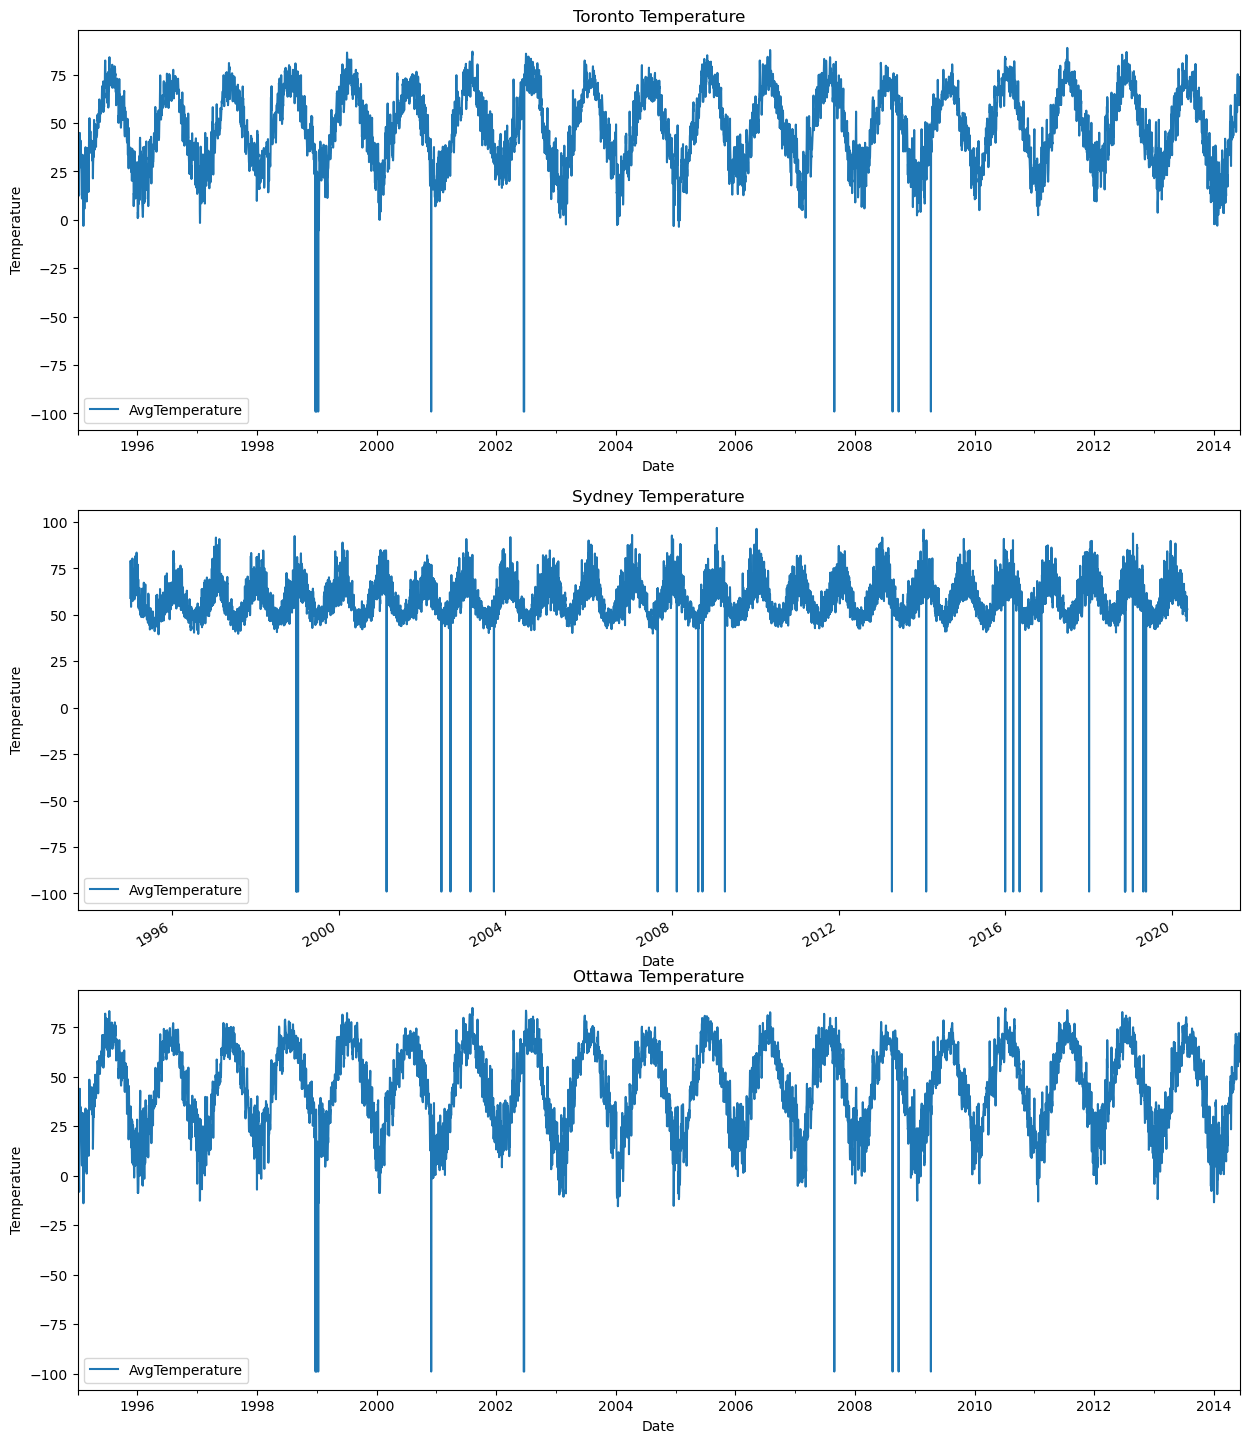

In [34]:
# Plot temperature data for each city in different subplots
fig, ax = plt.subplots(3, 1, figsize=(15,20))
city_1_df.plot(ax=ax[0], title=f"{city_1} Temperature", xlabel="Date", ylabel="Temperature")
city_2_df.plot(ax=ax[1], title=f"{city_2} Temperature", xlabel="Date", ylabel="Temperature")
city_3_df.plot(ax=ax[2], title=f"{city_3} Temperature", xlabel="Date", ylabel="Temperature")

<Axes: title={'center': 'Ottawa Monthly Temperature'}, xlabel='Date', ylabel='AvgTemperature'>

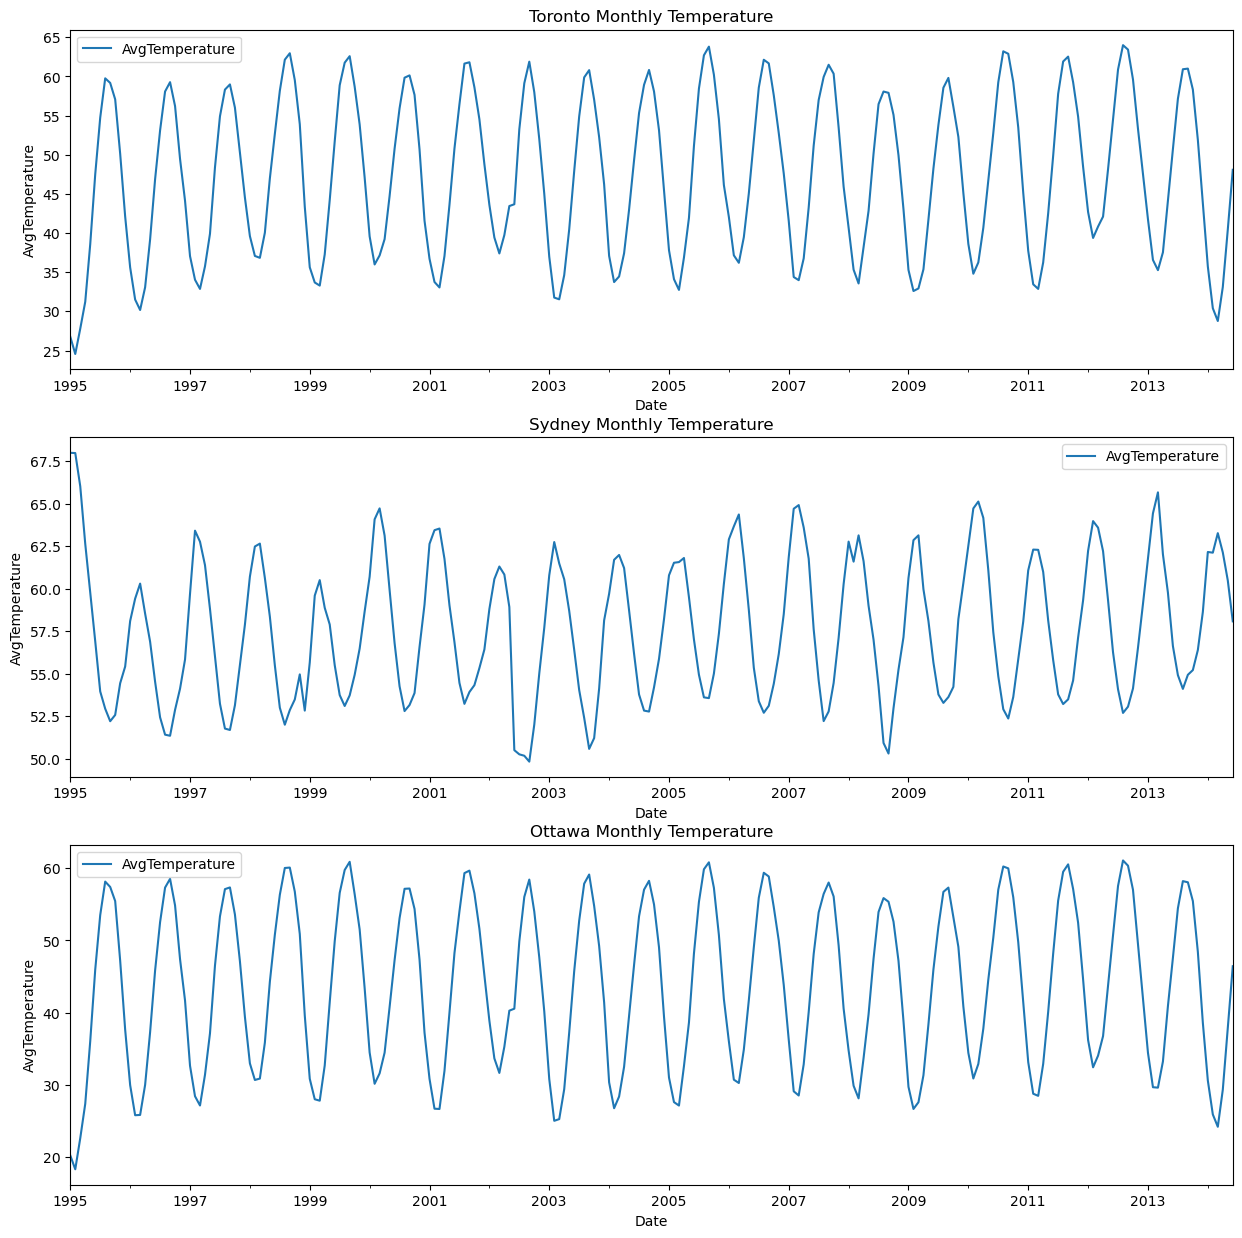

In [35]:
# Remove entries that aren't in intersection of all three indices (which are dates)
index_intersection = city_1_df.index.intersection(city_2_df.index).intersection(city_3_df.index)
city_1_df = city_1_df.loc[index_intersection]
city_2_df = city_2_df.loc[index_intersection]
city_3_df = city_3_df.loc[index_intersection]

# Downsample the data to monthly
city_1_monthly = city_1_df.resample('M').mean()
city_2_monthly = city_2_df.resample('M').mean()
city_3_monthly = city_3_df.resample('M').mean()

# Apply exponential smoothing to temperature data with alpha = 0.3
city_1_monthly = city_1_monthly.ewm(alpha=0.3, adjust=False).mean()
city_2_monthly = city_2_monthly.ewm(alpha=0.3, adjust=False).mean()
city_3_monthly = city_3_monthly.ewm(alpha=0.3, adjust=False).mean()

# Plot monthly temperature data for cities in different subplots
fig, ax = plt.subplots(3, 1, figsize=(15,15))
city_1_monthly.plot(ax=ax[0], y='AvgTemperature', title=f"{city_1} Monthly Temperature", xlabel="Date", ylabel="AvgTemperature")
city_2_monthly.plot(ax=ax[1], y='AvgTemperature', title=f"{city_2} Monthly Temperature", xlabel="Date", ylabel="AvgTemperature")
city_3_monthly.plot(ax=ax[2], y='AvgTemperature', title=f"{city_3} Monthly Temperature", xlabel="Date", ylabel="AvgTemperature")

Questions to ask yourself: What do these plots reveal about the data? What can you infer about the location (or proximity) of these cities from these plots?

Text(0, 0.5, 'Correlation')

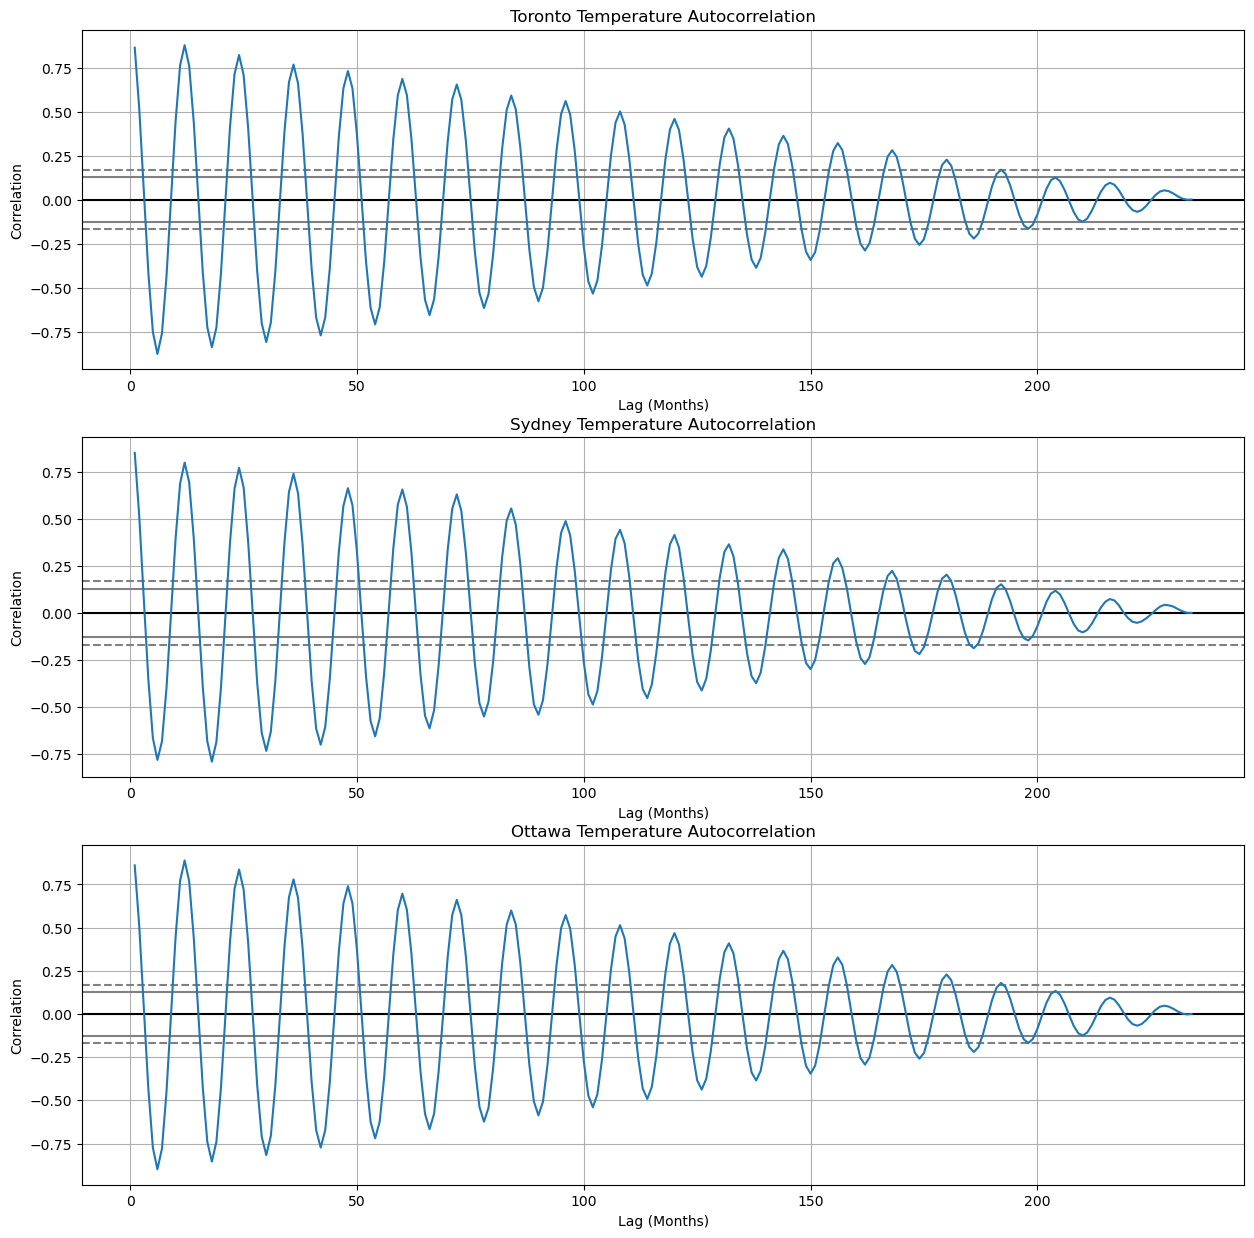

In [36]:
# Plot auto-correlation for temperature of cities in different subplots

fig, ax = plt.subplots(3, 1, figsize=(15,15))

pd.plotting.autocorrelation_plot(city_1_monthly['AvgTemperature'], ax=ax[0])
ax[0].set_title(f"{city_1} Temperature Autocorrelation")
ax[0].set_xlabel("Lag (Months)")
ax[0].set_ylabel("Correlation")

pd.plotting.autocorrelation_plot(city_2_monthly['AvgTemperature'], ax=ax[1])
ax[1].set_title(f"{city_2} Temperature Autocorrelation")
ax[1].set_xlabel("Lag (Months)")
ax[1].set_ylabel("Correlation")

pd.plotting.autocorrelation_plot(city_3_monthly['AvgTemperature'], ax=ax[2])
ax[2].set_title(f"{city_3} Temperature Autocorrelation")
ax[2].set_xlabel("Lag (Months)")
ax[2].set_ylabel("Correlation")

The periodic peaks/valleys in the autocorrelation plots is evidence of seasonality. The period is about 12 months which is a calendar year. The peaks occur when lagging the data aligns the seasons (e.g. winter-winter, summer-summer). The valleys occur when lagging the data misaligns the seasons (e.g. winter-summer, summer-winter). Note that the decreasing magnitude of the peaks/valleys suggest the presence of a trend as well (e.g. warmer temperatures due to climate change).

### Cross-Correlation

Cross-correlation accomplishes the same thing as autocorrelation, except with two different time-series data sources. One of the time-series signals is shifted across different lags to compute correlation (similar to autocorrelation).

Text(0, 0.5, 'Correlation')

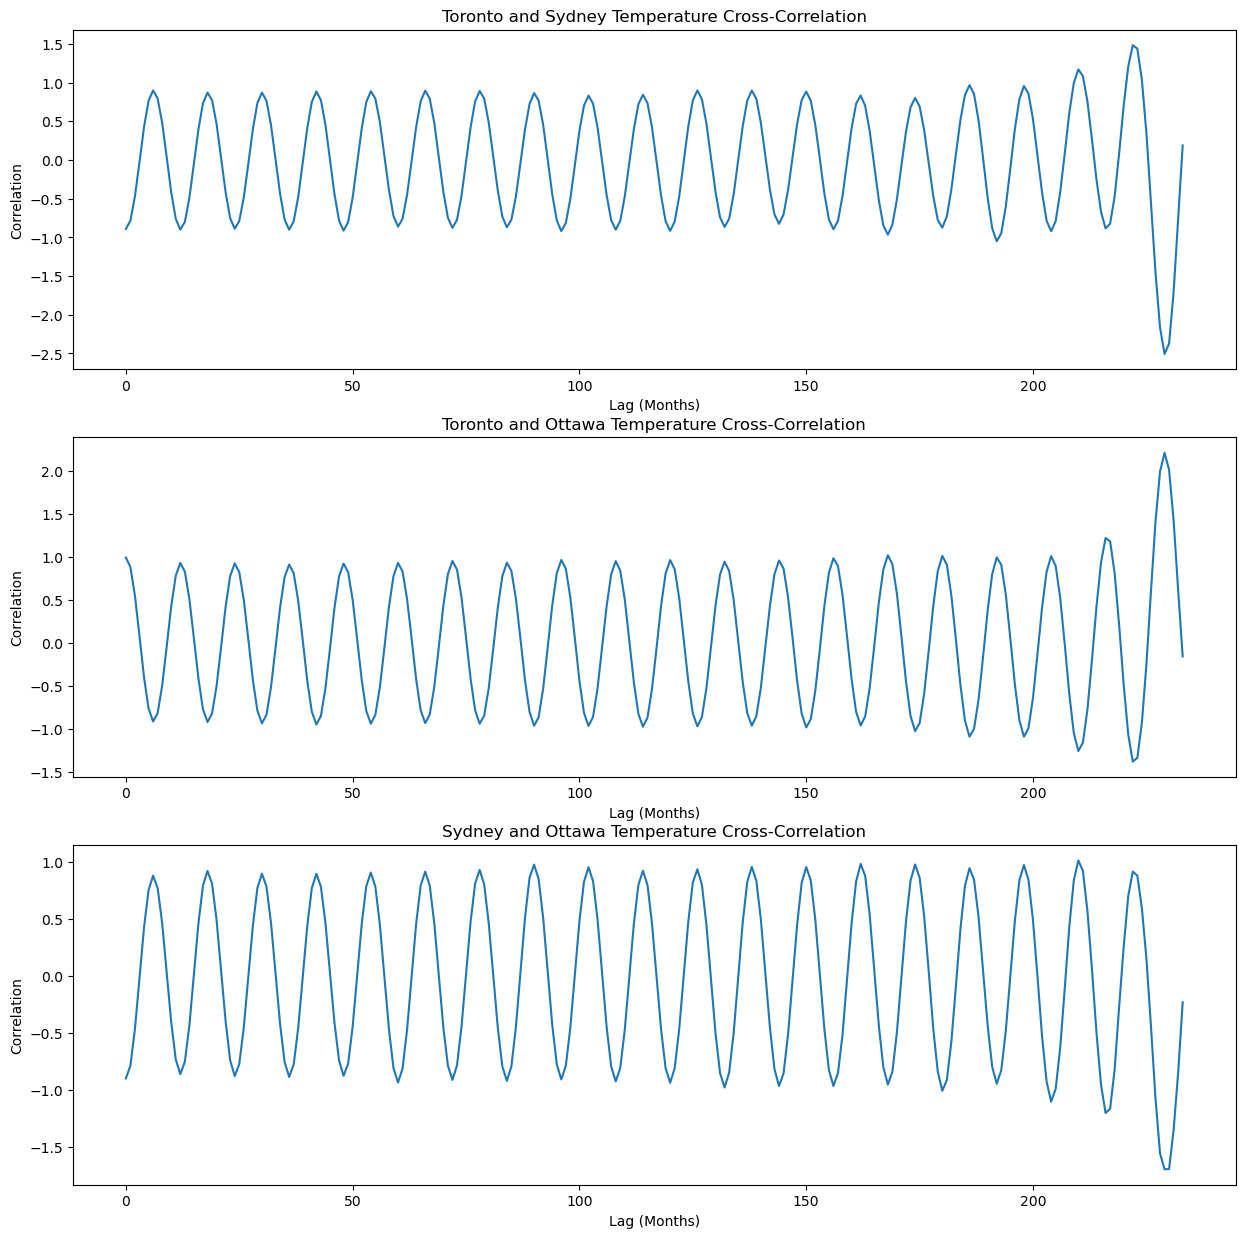

In [37]:
# Plot cross-correlation between city temperature pairs

fig, ax = plt.subplots(3, 1, figsize=(15,15))

ccf_12 = ccf(city_1_monthly['AvgTemperature'], city_2_monthly['AvgTemperature'])
ccf_13 = ccf(city_1_monthly['AvgTemperature'], city_3_monthly['AvgTemperature'])
ccf_23 = ccf(city_2_monthly['AvgTemperature'], city_3_monthly['AvgTemperature'])

ax[0].plot(ccf_12)
ax[0].set_title(f"{city_1} and {city_2} Temperature Cross-Correlation")
ax[0].set_xlabel("Lag (Months)")
ax[0].set_ylabel("Correlation")

ax[1].plot(ccf_13)
ax[1].set_title(f"{city_1} and {city_3} Temperature Cross-Correlation")
ax[1].set_xlabel("Lag (Months)")
ax[1].set_ylabel("Correlation")

ax[2].plot(ccf_23)
ax[2].set_title(f"{city_2} and {city_3} Temperature Cross-Correlation")
ax[2].set_xlabel("Lag (Months)")
ax[2].set_ylabel("Correlation")

The plot shows that the seasonal cycle for Toronto/Ottawa and Sydney differ by 6 months, while Toronto and Ottawa share the same seasonal cycle.

### OPTIONAL: More Visualizations

This section presents a series of visualizations that can uncover important correlations.

#### Lag Plots

Useful for forecasting (predicting future values) by relating past values to future values.

Text(0.5, 1.0, 'Sydney Temperature Lag Plot')

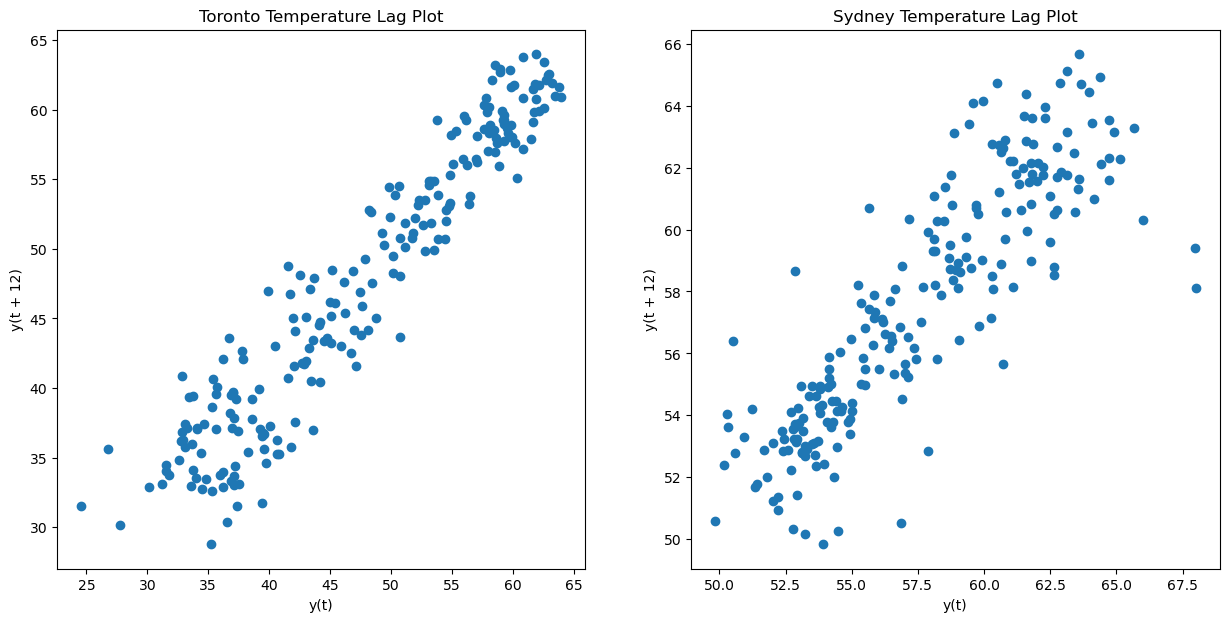

In [38]:
# Lag plot for Toronto and Sydney temperature
fig, ax = plt.subplots(1, 2, figsize=(15,7))
pd.plotting.lag_plot(city_1_monthly['AvgTemperature'], ax=ax[0], lag=12) # lag = 12 means 12 months
ax[0].set_title(f"{city_1} Temperature Lag Plot")
pd.plotting.lag_plot(city_2_monthly['AvgTemperature'], ax=ax[1], lag=12)
ax[1].set_title(f"{city_2} Temperature Lag Plot")

Question to ask yourself: what is the line of best fit and why?

#### Heatmaps

In [39]:
# Format the data to have 4 columns: Google_Adj_Close, Amazon_Adj_Close, Google_Volume, Amazon_Volume
stocks_corr = stocks_df.pivot(columns='company_name')
stocks_corr.columns = stocks_corr.columns.droplevel()
stocks_corr.columns = ['Google_Adj_Close', 'Amazon_Adj_Close', 'Google_Volume', 'Amazon_Volume']
stocks_corr

Google_Adj_Close  Amazon_Adj_Close  Google_Volume  Amazon_Volume
Date                                                                        
2019-02-19         81.378998         55.928001       73634000       20928000
2019-02-20         81.105003         55.689999       66752000       21756000
2019-02-21         80.972000         54.848499       69668000       28302000
2019-02-22         81.578003         55.518501       61924000       20990000
2019-02-25         81.650002         55.470001       63690000       28262000
...                      ...               ...            ...            ...
2024-02-12        172.339996        148.729996       51050400       17236100
2024-02-13        168.639999        146.369995       56345100       18138500
2024-02-14        170.979996        147.139999       42815500       16651800
2024-02-15        169.800003        143.940002       49855200       26724300
2024-02-16        169.509995        141.759995       48074600       21849700

[1259 rows x 4 columns]

Text(0.5, 1.0, 'Correlation between Stock Prices and Volume')

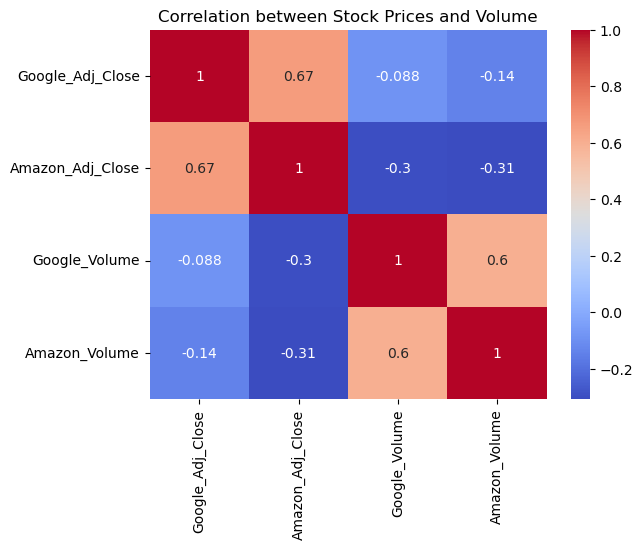

In [40]:
# 4x4 heatmap of correlation between stock prices and volume
sns.heatmap(stocks_corr.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation between Stock Prices and Volume")

#### Pairplot

c:\Users\esmat\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


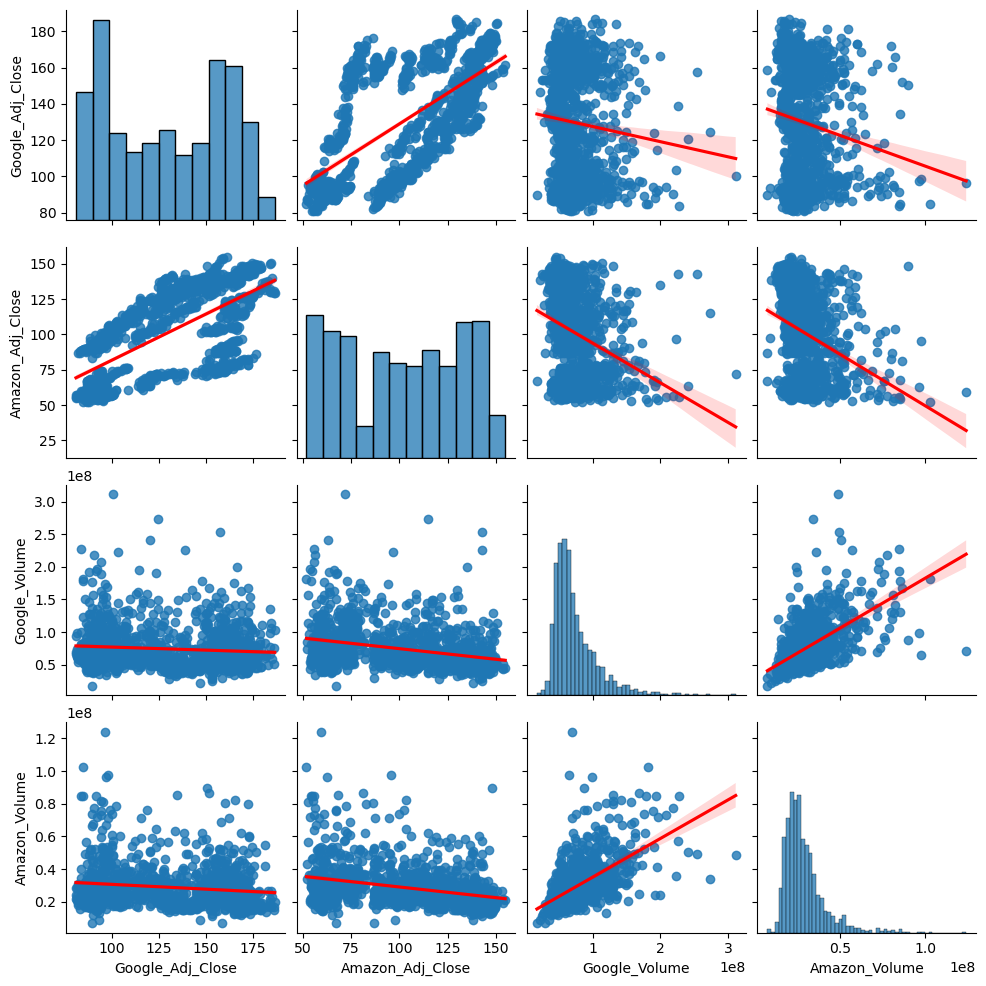

In [41]:
# 4x4 joint plot of stock prices and volume
sns.pairplot(stocks_corr, kind='reg', plot_kws={'line_kws':{'color':'red'}}) # kind='reg' adds a regression line to the scatter plot